<a href="https://colab.research.google.com/github/aqn96/SemanticSounds/blob/master/recommender_src/music_recommender_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Go to file ==> drive ==> MyDrive ==> CollabNotebooks

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install thefuzz[speedup]
!pip install fuzzywuzzy python-Levenshtein
!pip install pandas rapidfuzz
!pip install recordlinkage
!pip install metaphone
!pip install plotly

### ML Records
Main Question: Are there musical features that predict the popularity of a song

Objective: Can we construct a popular song? Can we predict a viral song?Initial importance to us:
- Segun:
  - Are music trends are cyclical? Is there a pattern or trend for music that transcends time.
- An:
  - Can this model help them find something insightful about their own music or the industry as a whole?
- Andrew:
  - How do artists lyrics impact people? How big is the lyrical factor in song or genre virality?

## Data:

In [ ]:
# Mass Import

# Import Essentials
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import numpy as np

# Import libraries for modeling and evaluation
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN # import DBSCAN class
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Feature Importance using SHAP
import shap

# Import XGBoost and LightGBM
import xgboost as xgb
import lightgbm as lgb

# Ignore warnings for clean output
import warnings
warnings.filterwarnings('ignore')

# fuzzy matching
from thefuzz import process
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
file_10_thousand = 'top_10000_1950-now.csv'
file_60_thousand = 'spotify_60000_songs.csv'

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/top_10000_1950-now.csv')
# df1.head()

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/spotify_60000_songs.csv')
# df2.head()

In [ ]:
# Looking at the shape of the dataframes
print(df1.shape)
print(df2.shape)

(10000, 35)
(57650, 4)


In [ ]:
# looking into df1
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Track URI             10000 non-null  object 
 1   Track Name            9998 non-null   object 
 2   Artist URI(s)         9998 non-null   object 
 3   Artist Name(s)        9998 non-null   object 
 4   Album URI             9998 non-null   object 
 5   Album Name            9998 non-null   object 
 6   Album Artist URI(s)   9998 non-null   object 
 7   Album Artist Name(s)  9998 non-null   object 
 8   Album Release Date    9998 non-null   object 
 9   Album Image URL       9996 non-null   object 
 10  Disc Number           10000 non-null  int64  
 11  Track Number          10000 non-null  int64  
 12  Track Duration (ms)   10000 non-null  int64  
 13  Track Preview URL     9937 non-null   object 
 14  Explicit              10000 non-null  bool   
 15  Popularity          

In [ ]:
# Check for exact matches of "Taylor Swift" in the 'Artist Name(s)' column. Verification dataset is intact.
taylor_present_exact = df1['Artist Name(s)'].str.lower().str.strip().eq('taylor swift').any()

if taylor_present_exact:
    print("Taylor Swift is present in the dataset (exact match).")
else:
    print("Taylor Swift is NOT present in the dataset (exact match).")

Taylor Swift is present in the dataset (exact match).


In [ ]:
# Looking into df2
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [ ]:
# Columns with missing values from df1 (10000 songs) and their counts
missing_values = df1.isnull().sum()
print(missing_values)

Track URI                   0
Track Name                  2
Artist URI(s)               2
Artist Name(s)              2
Album URI                   2
Album Name                  2
Album Artist URI(s)         2
Album Artist Name(s)        2
Album Release Date          2
Album Image URL             4
Disc Number                 0
Track Number                0
Track Duration (ms)         0
Track Preview URL          63
Explicit                    0
Popularity                  0
ISRC                        4
Added By                    0
Added At                    0
Artist Genres             551
Danceability                5
Energy                      5
Key                         5
Loudness                    5
Mode                        5
Speechiness                 5
Acousticness                5
Instrumentalness            5
Liveness                    5
Valence                     5
Tempo                       5
Time Signature              5
Album Genres            10000
Label     

In [ ]:
# Missing values from df2 (60000 songs)
# We can see that there's no missing values in this dataset
df2.isnull().sum()

artist    0
song      0
link      0
text      0
dtype: int64

In [ ]:
# Finding duplicate rows
duplicate_rows = df1[df1.duplicated(keep='first')]

# Number of duplicate rows
num_duplicates = duplicate_rows.shape[0]

# Displaying the duplicate rows
print(f"Number of duplicate rows: {num_duplicates}")
# duplicate_rowsdf1

Number of duplicate rows: 47


In [ ]:
# Finding duplicate rows
duplicate_rows2 = df2[df2.duplicated(keep='first')]

# Number of duplicate rows
num_duplicates2 = duplicate_rows2.shape[0]

# Displaying the duplicate rows
print(f"Number of duplicate rows in df2: {num_duplicates2}")
# duplicate_rowsdf2

Number of duplicate rows in df2: 0


In [ ]:
# Remove duplicates and update the DataFrame
df1.drop_duplicates(keep='first', inplace=True)

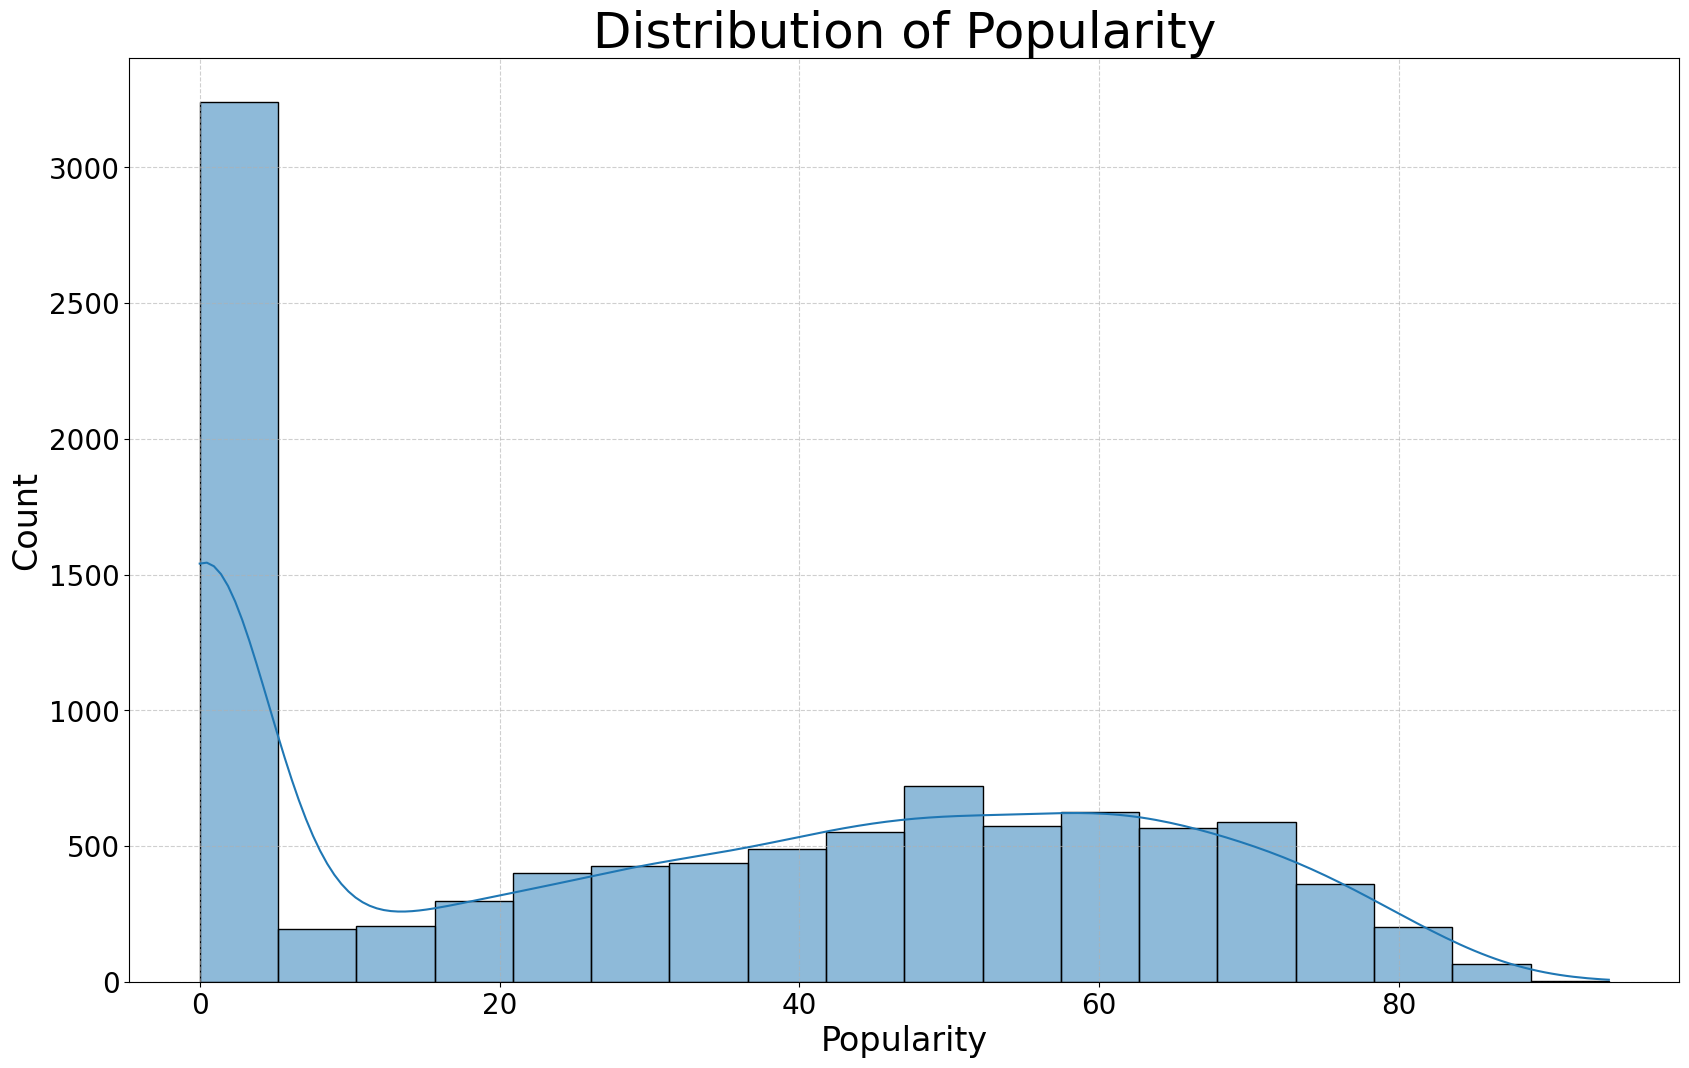

In [ ]:
# Distribution of Popularity

plt.figure(figsize=(20, 12))
sns.histplot(df1['Popularity'], kde=True)
plt.title('Distribution of Popularity', fontsize=36)
plt.xlabel('Popularity', fontsize=24)
plt.ylabel('Count', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("poster_figure1.png", dpi=300, bbox_inches="tight")
plt.show()

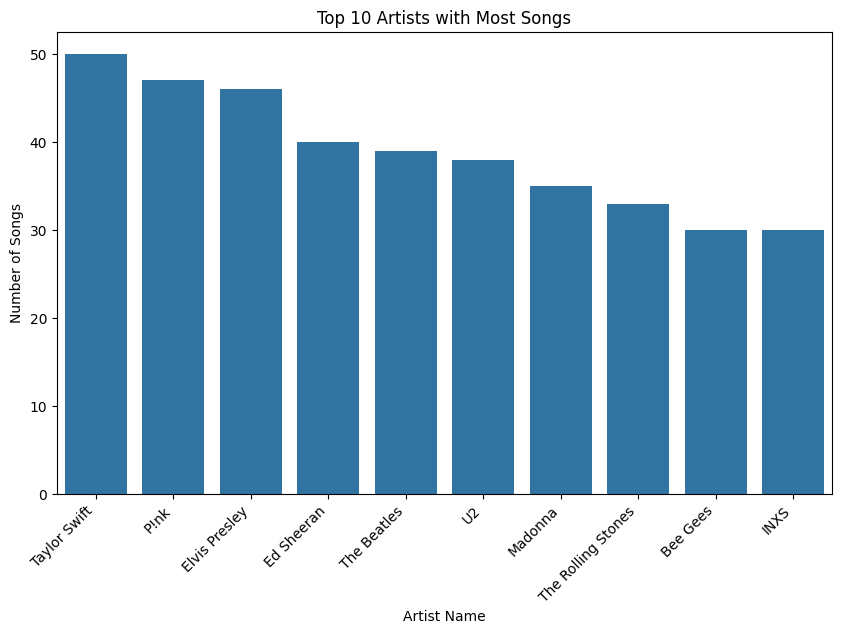

In [ ]:
# The top 10 artists with the most tracks in dataset 1. Barplot
top_artists = df1['Artist Name(s)'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_artists.index, y=top_artists.values)
plt.title('Top 10 Artists with Most Songs')
plt.xlabel('Artist Name')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45, ha='right')
plt.show()


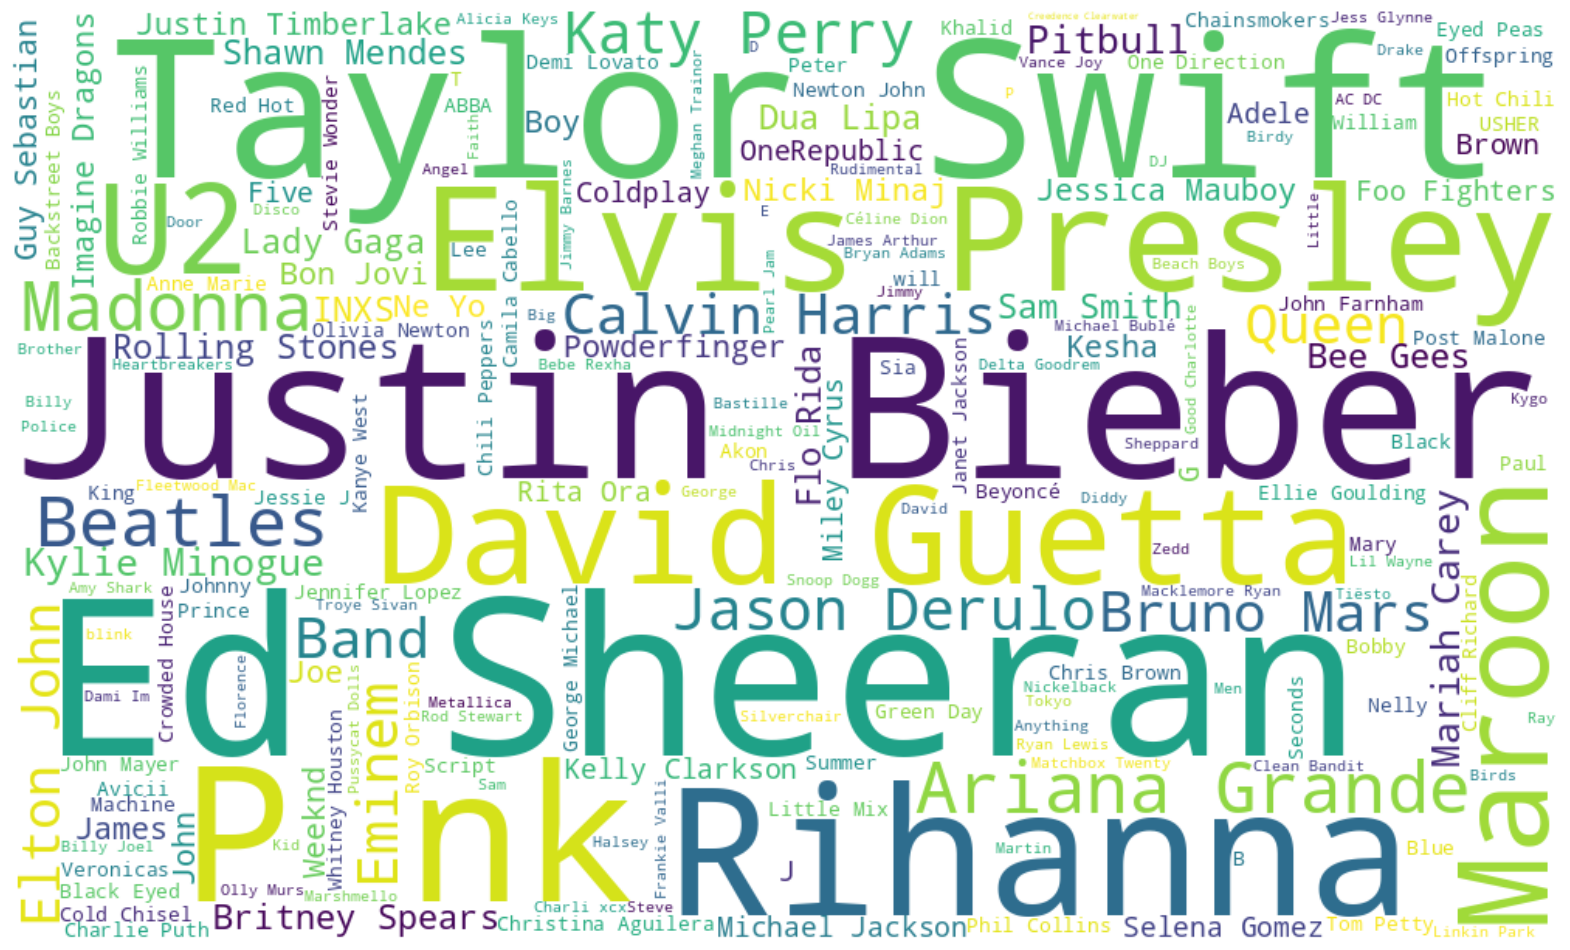

In [ ]:
# Combine all artist names into a single string
all_artist_names = ' '.join(df1['Artist Name(s)'].astype(str))

# Create a WordCloud object
wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='viridis').generate(all_artist_names)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

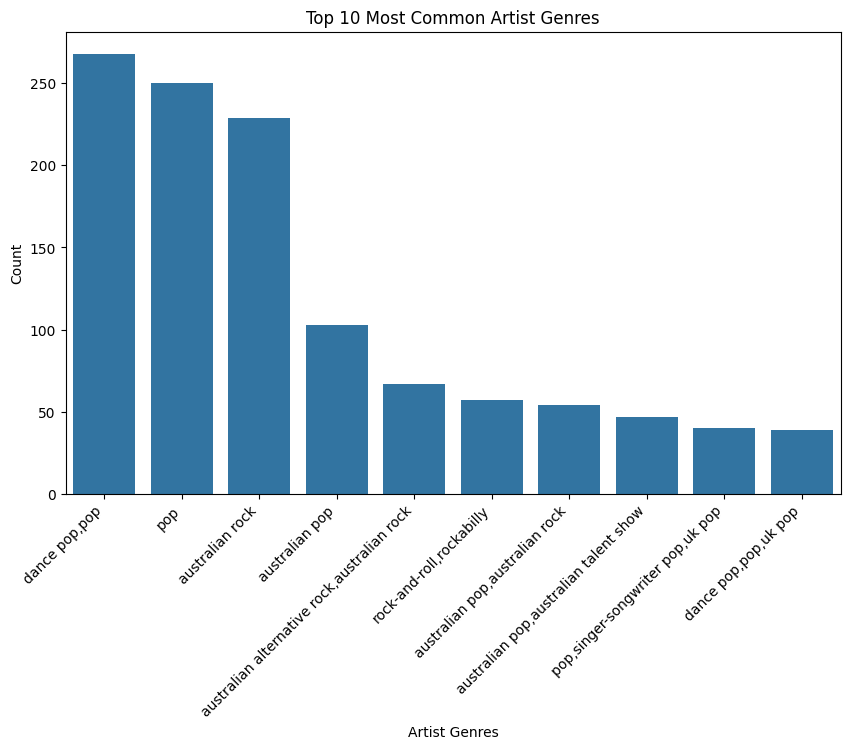

In [ ]:
# Top 10 most common artist genres from dataset 1
top_artist_genres = df1['Artist Genres'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_artist_genres.index, y=top_artist_genres.values)
plt.title('Top 10 Most Common Artist Genres')
plt.xlabel('Artist Genres')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

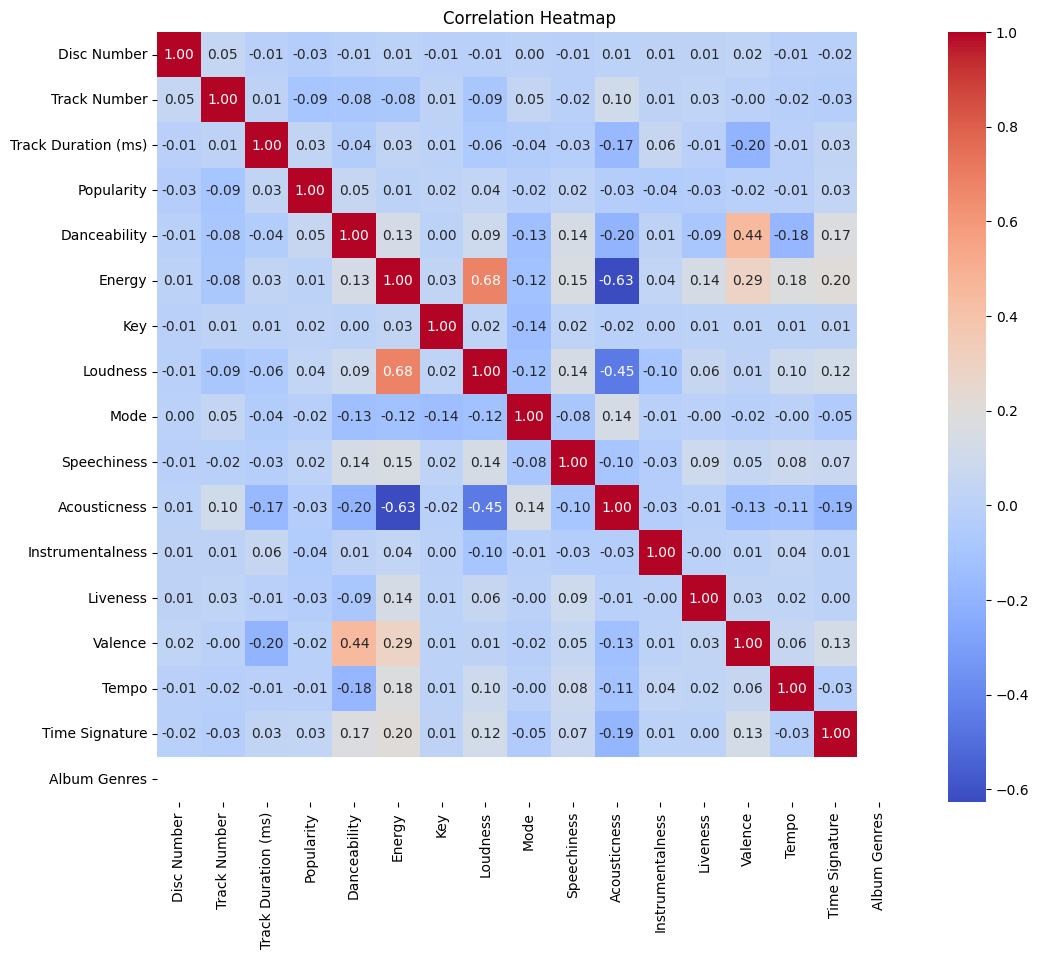

In [ ]:
# Correlation Heatmap for numeric columns
df1_number = df1.select_dtypes(include=['number'])

plt.figure(figsize=(12, 10))
sns.heatmap(df1_number.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

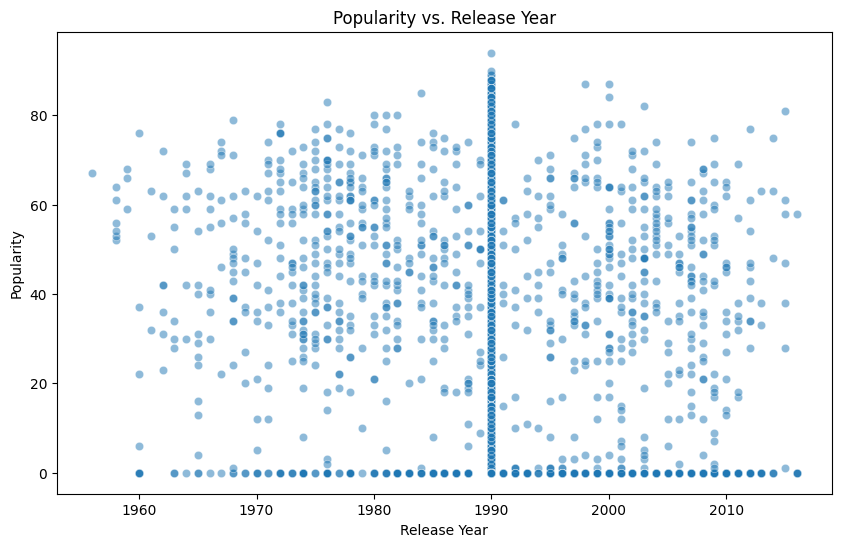

In [ ]:
# # Convert the 'Album Release Date' column to datetime

# Filter out rows with invalid dates in 'Album Release Date'
df1['Album Release Date'] = pd.to_datetime(df1['Album Release Date'], errors='coerce')

# Drop rows with invalid dates (NaT) from the DataFrame
# df1.dropna(subset=['Album Release Date'], inplace=True)
median_year = df1['Album Release Date'].median()
df1['Album Release Date'] = df1['Album Release Date'].fillna(median_year)

# Extract the year from the release date
df1['Release Year'] = df1['Album Release Date'].dt.year

# Popularity vs. Release Year
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df1, x='Release Year', y='Popularity', alpha=0.5)
plt.title('Popularity vs. Release Year')
plt.xlabel('Release Year')
plt.ylabel('Popularity')
plt.show()

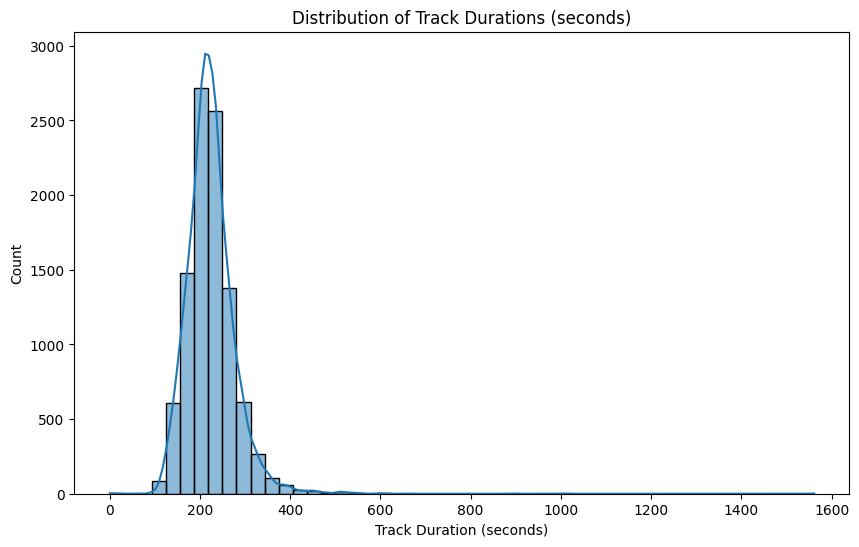

In [ ]:
# Distribution of Track Durations

plt.figure(figsize=(10, 6))
sns.histplot(df1['Track Duration (ms)'] / 1000, bins=50, kde=True)
plt.title('Distribution of Track Durations (seconds)')
plt.xlabel('Track Duration (seconds)')
plt.ylabel('Count')
plt.show()

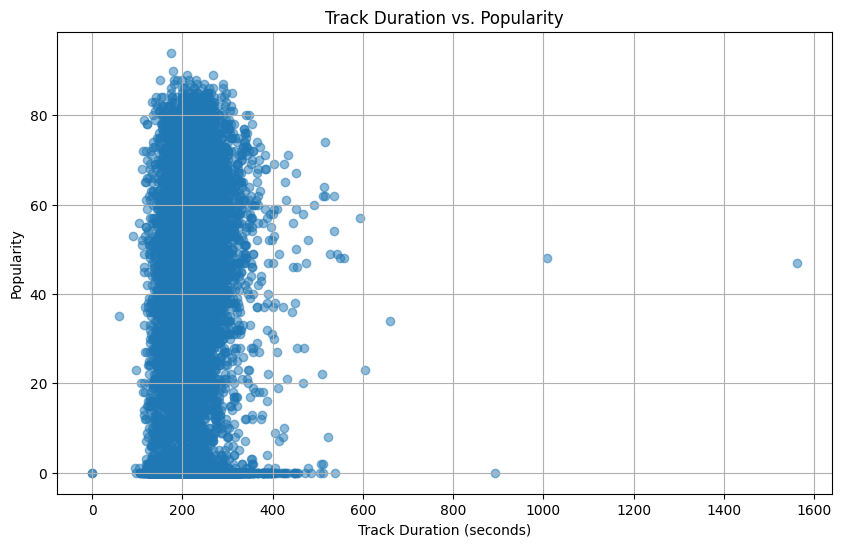

In [ ]:
# Track Duration with Popularity

# Convert 'Track Duration (ms)' to seconds
df1['Track Duration (seconds)'] = df1['Track Duration (ms)'] / 1000

# Create a scatter plot of track duration vs. popularity
plt.figure(figsize=(10, 6))
plt.scatter(df1['Track Duration (seconds)'], df1['Popularity'], alpha=0.5)
plt.xlabel('Track Duration (seconds)')
plt.ylabel('Popularity')
plt.title('Track Duration vs. Popularity')
plt.grid(True)
plt.show()

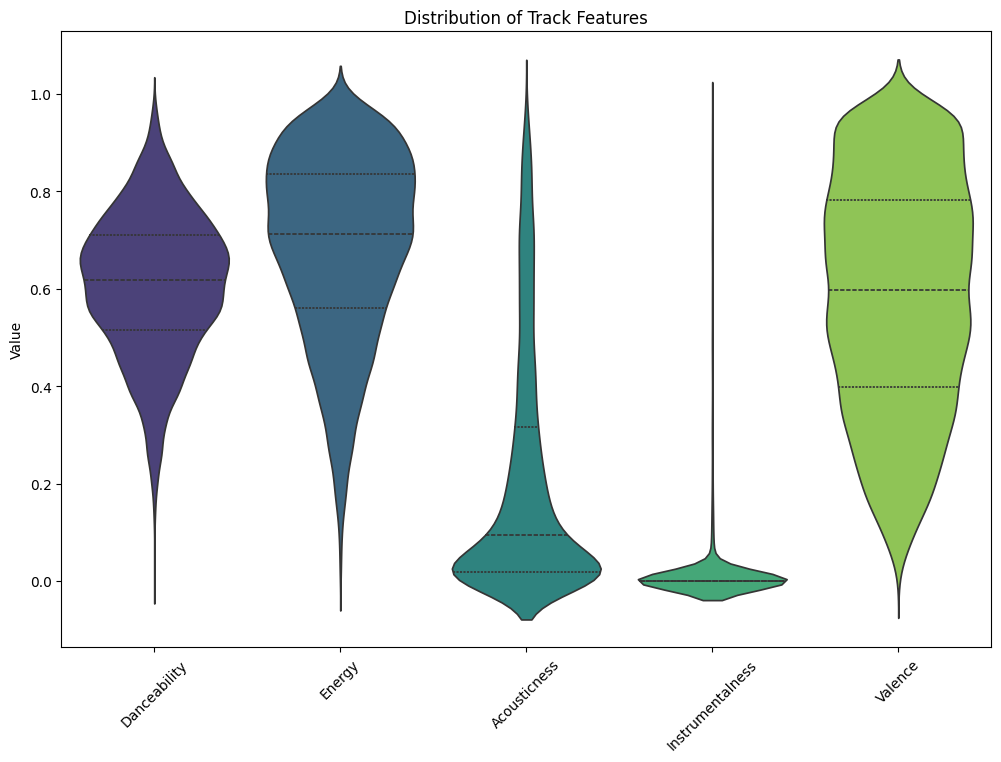

In [ ]:
# Selecting relevant features for visualization
selected_features = df1[['Danceability', 'Energy', 'Acousticness', 'Instrumentalness', 'Valence']]

# Violin plots for selected track features
plt.figure(figsize=(12, 8))
sns.violinplot(data=selected_features, palette='viridis', inner='quartile')
plt.title('Distribution of Track Features')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()

**Feature Description Link**: https://developer.spotify.com/documentation/web-api/reference/get-audio-features

**danceability**
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

**energy**
Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

**acousticness**
A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
Range: 0 - 1Example: 0.00242

**instrumentalness**
Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

**valence**
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
Range: 0 - 1 Example: 0.428

**tempo**
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
Example: 118.211

**loudness**
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
Example: -5.883

**speechiness**
Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
Example: 0.0556

**liveness**
Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
Example: 0.0866

**popularity**
The popularity of the track. The value will be between 0 and 100, with 100 being the most popular.
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note: the popularity value may lag actual popularity by a few days: the value is not updated in real time.

In [ ]:
# Check for exact matches of "Taylor Swift" in the 'Artist Name(s)' column. Verification dataset is intact.
taylor_present_exact = df1['Artist Name(s)'].str.lower().str.strip().eq('taylor swift').any()

if taylor_present_exact:
    print("Taylor Swift is present in the dataset (exact match).")
else:
    print("Taylor Swift is NOT present in the dataset (exact match).")

Taylor Swift is present in the dataset (exact match).


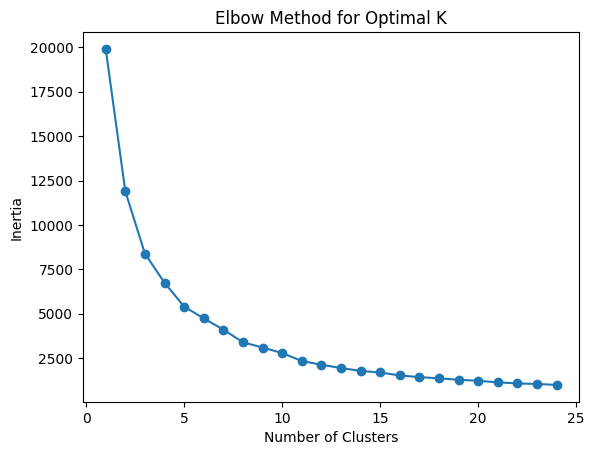

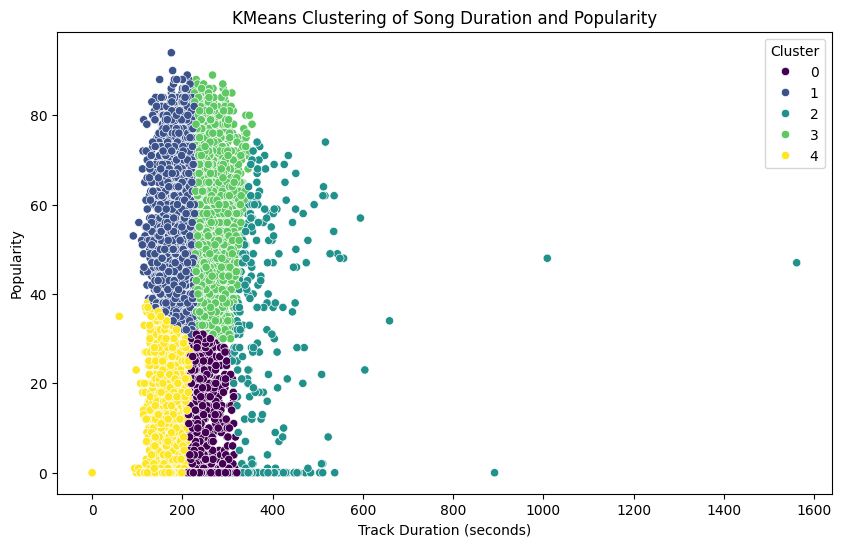

         Track Duration (seconds)  Popularity
Cluster                                      
0                      247.101194    5.351707
1                      194.463088   55.822833
2                      384.832265   25.541538
3                      260.608726   56.888992
4                      177.718164    8.795486


In [ ]:
# Kmeans clustering looking at song durations and cluster it in context of popularity

# Prepare the data for KMeans clustering
X_kmeans = df1[['Track Duration (seconds)', 'Popularity']]

# Standardize the data (important for KMeans)
scaler = StandardScaler()
X_kmeans_scaled = scaler.fit_transform(X_kmeans)

# Determine the optimal number of clusters using the elbow method (optional)
inertia = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_kmeans_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 25), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Based on the elbow method or your preference, choose the number of clusters
n_clusters = 5

# Perform KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_kmeans_scaled)

# Add the cluster labels to the DataFrame
df1['Cluster'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Track Duration (seconds)', y='Popularity', hue='Cluster', data=df1, palette='viridis')
plt.title('KMeans Clustering of Song Duration and Popularity')
plt.xlabel('Track Duration (seconds)')
plt.ylabel('Popularity')
plt.show()

# Analyze the characteristics of each cluster
print(df1.groupby('Cluster')[['Track Duration (seconds)', 'Popularity']].mean())

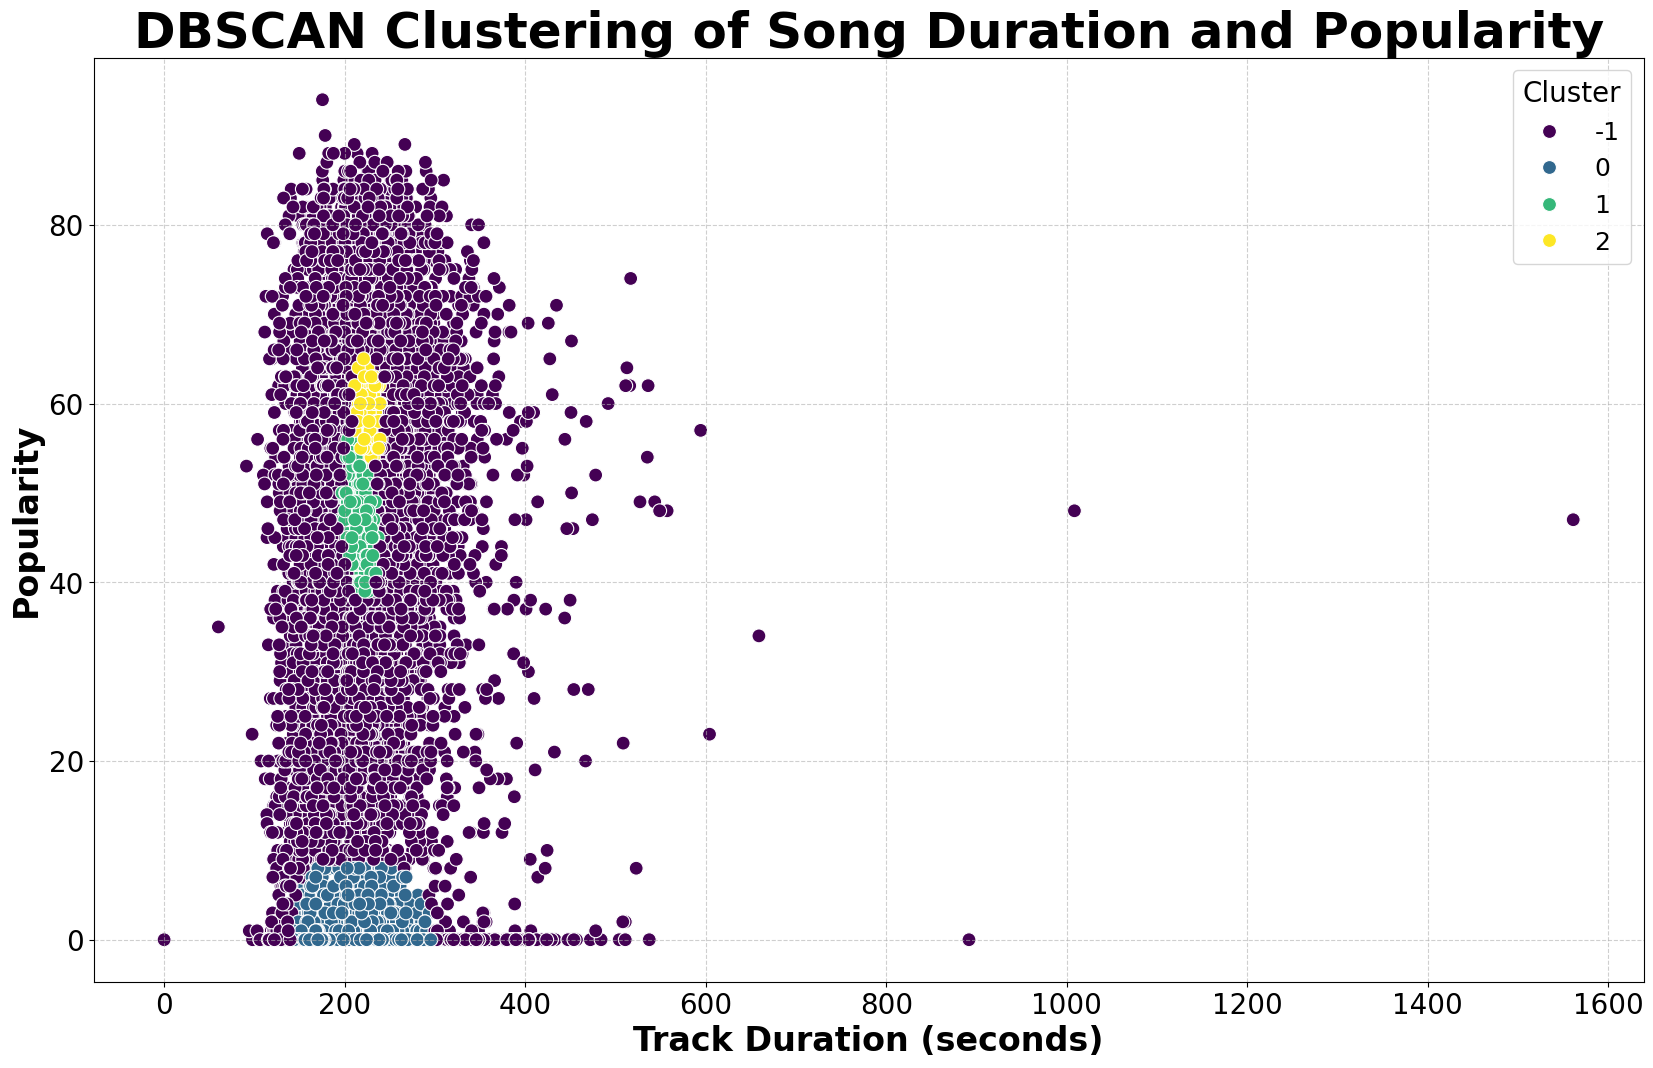

In [ ]:
# Dbscan clustering looking at song durations and cluster it in context of popularity

# Prepare the data for DBSCAN clustering
X_dbscan = df1[['Track Duration (seconds)', 'Popularity']]

# Standardize the data (important for DBSCAN)
scaler = StandardScaler()
X_dbscan_scaled = scaler.fit_transform(X_dbscan)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.18, min_samples=175)  # Adjust eps and min_samples
dbscan.fit(X_dbscan_scaled)

# Add the cluster labels to the DataFrame
df1['DBSCAN_Cluster'] = dbscan.labels_

# Visualize the clusters
plt.figure(figsize=(20, 12))
sns.scatterplot(
    x='Track Duration (seconds)',
    y='Popularity',
    hue='DBSCAN_Cluster',
    data=df1,
    palette='viridis',
    s=100  # Adjust marker size for better visibility
)
plt.title('DBSCAN Clustering of Song Duration and Popularity', fontsize=36, fontweight='bold')
plt.xlabel('Track Duration (seconds)', fontsize=24, fontweight='bold')
plt.ylabel('Popularity', fontsize=24, fontweight='bold')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=18, title='Cluster', title_fontsize=20, loc='best')  # Adjust legend font sizes
plt.savefig("poster_figure2.png", dpi=300, bbox_inches="tight")  # Save the figure for poster quality


# Analyze the characteristics of each cluster
summary = df1.groupby('DBSCAN_Cluster')[['Track Duration (seconds)', 'Popularity']].mean()

# Display the styled summary table with larger font size
import pandas.io.formats.style

styled_summary = summary.style.set_table_attributes('style="font-size: 20px;"')  # Set font size for styled output
styled_summary
plt.savefig("poster_figure2.png", dpi=300, bbox_inches="tight")
plt.show()

Filled missing values in 'Danceability' with median value: 0.618
Filled missing values in 'Energy' with median value: 0.713
Filled missing values in 'Acousticness' with median value: 0.09525
Filled missing values in 'Instrumentalness' with median value: 5.665e-06
Filled missing values in 'Valence' with median value: 0.598
Filled missing values in 'Speechiness' with median value: 0.0429
Filled missing values in 'Liveness' with median value: 0.127
Filled missing values in 'Tempo' with median value: 120.7485
Filled missing values in 'Loudness' with median value: -6.492

Missing Values After Imputation (Numerical Features):
Danceability        0
Energy              0
Acousticness        0
Instrumentalness    0
Valence             0
Speechiness         0
Liveness            0
Tempo               0
Loudness            0
Popularity          0
dtype: int64

Filled missing 'Album Release Date' with median date: 1990-07-02 12:00:00

Missing Values After Imputation (Release Date Features):
Releas

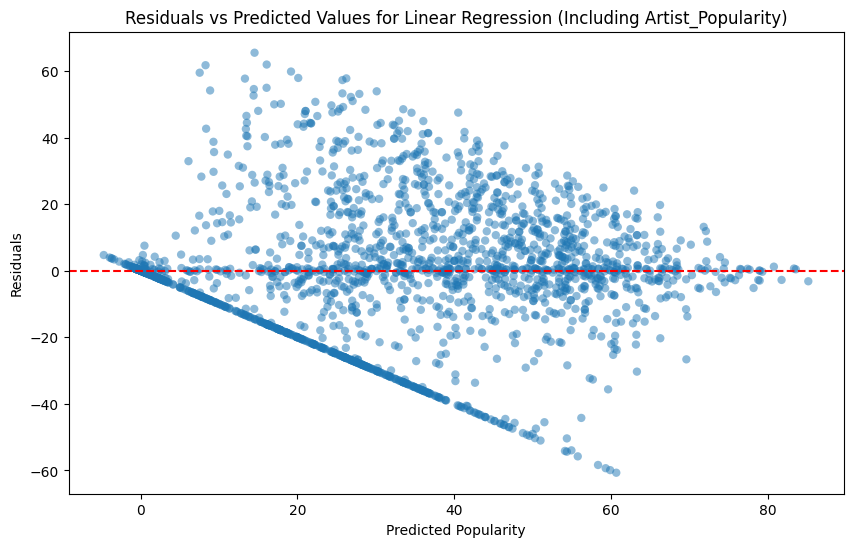

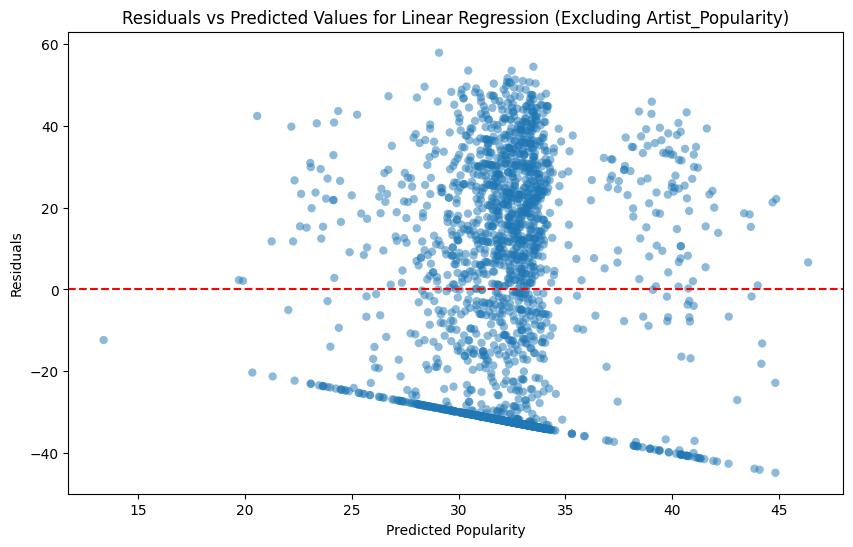


Feature Importances from Random Forest Regressor (Including Artist_Popularity):
             Feature  Importance
8  Artist_Popularity    0.582805
1        Speechiness    0.098596
0       Acousticness    0.098258
3           Loudness    0.098171
2           Liveness    0.095215
4        Age_of_Song    0.016473
6           Explicit    0.006374
5        Major_Label    0.002593
7    is_instrumental    0.001515


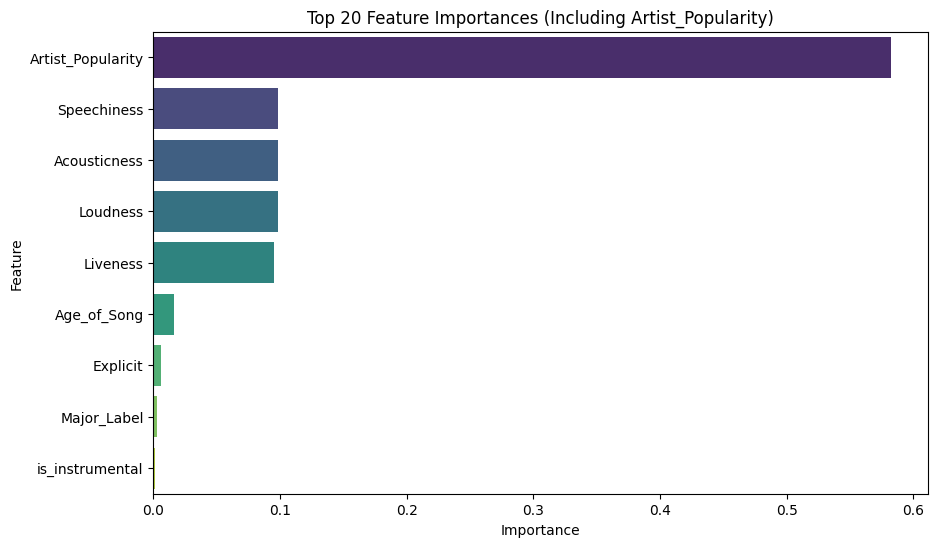


Feature Importances from Random Forest Regressor (Excluding Artist_Popularity):
           Feature  Importance
3         Loudness    0.244238
0     Acousticness    0.243476
2         Liveness    0.234235
1      Speechiness    0.233664
4      Age_of_Song    0.030520
6         Explicit    0.005776
7  is_instrumental    0.004478
5      Major_Label    0.003614


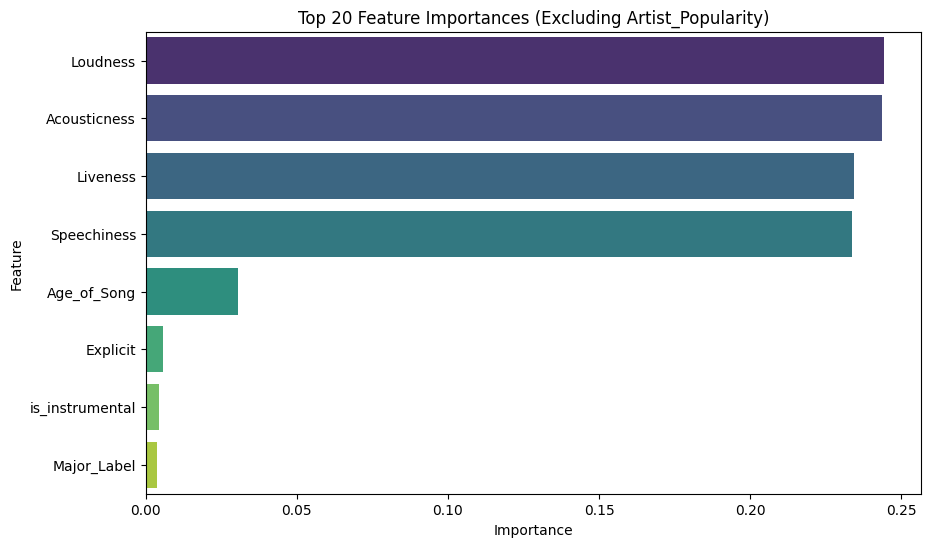

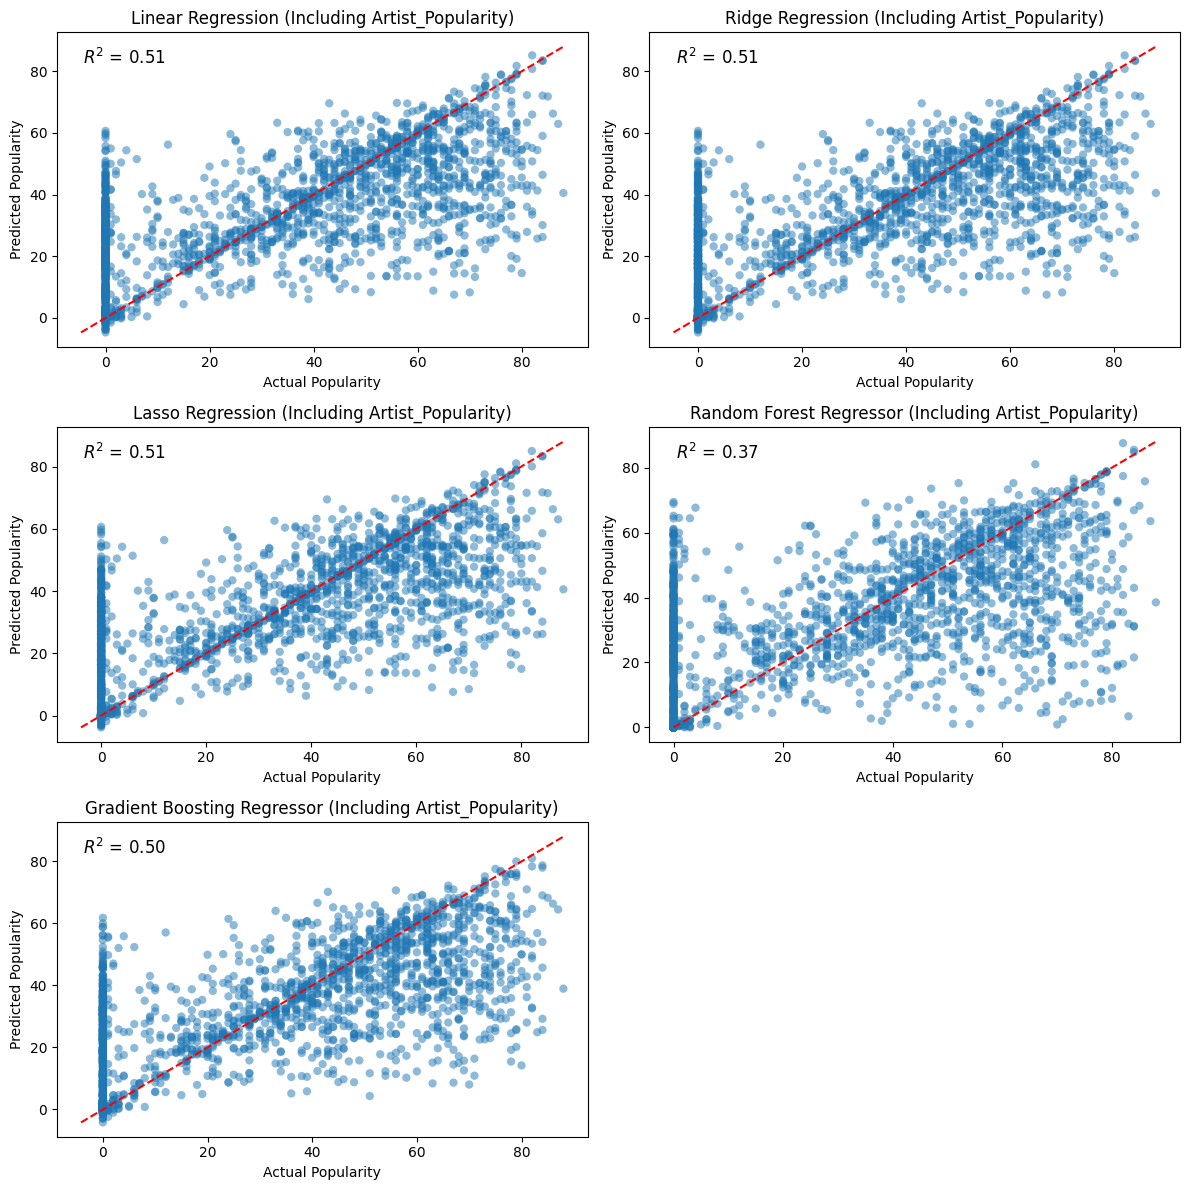

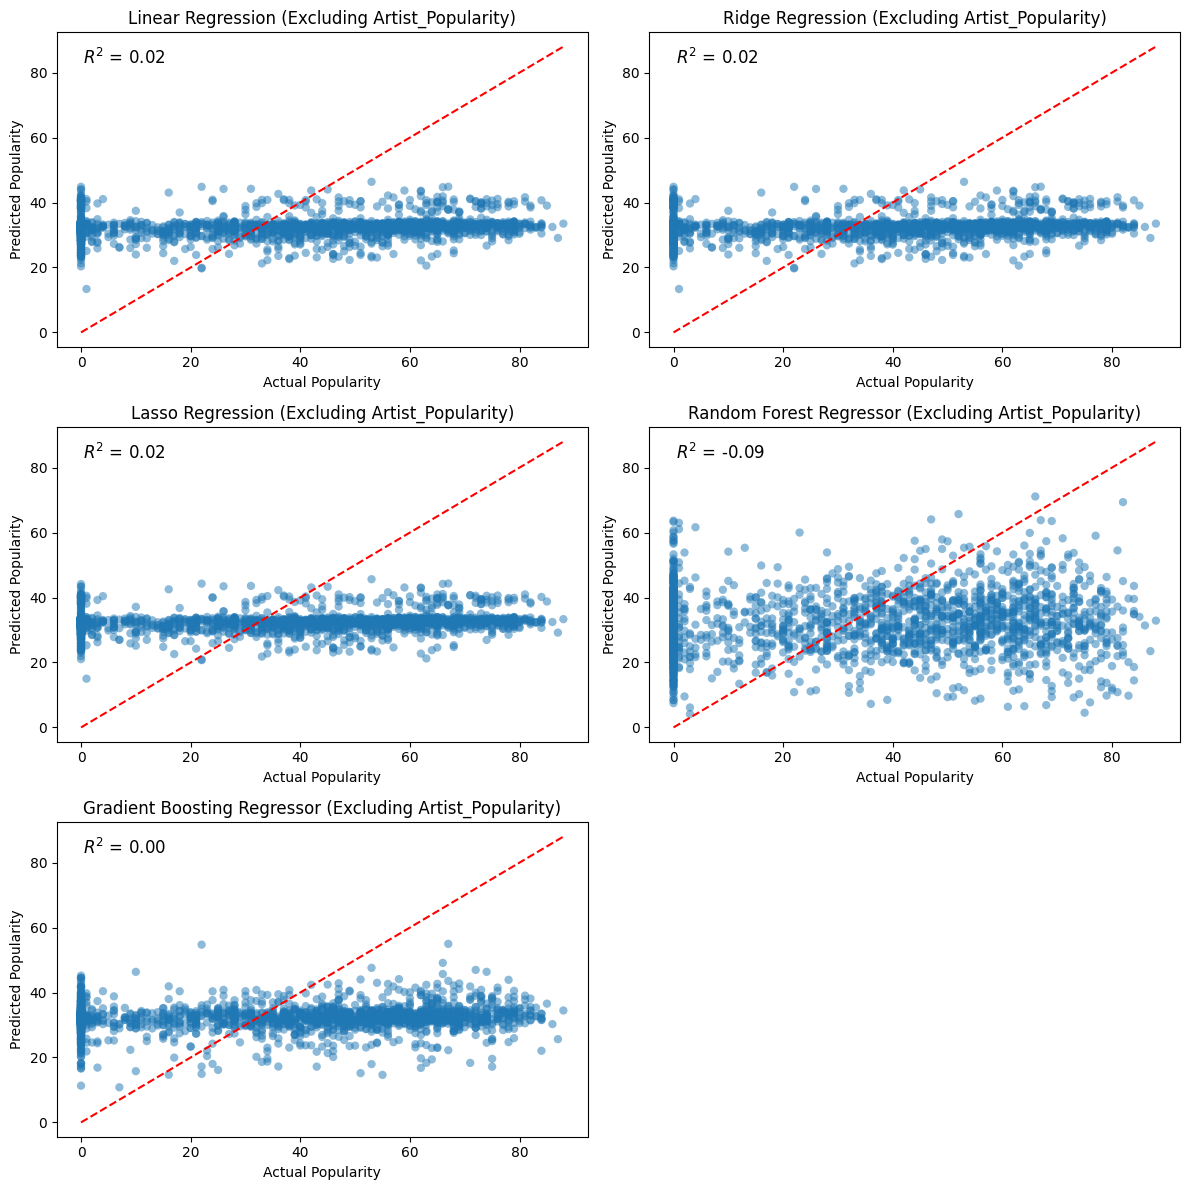


--- Comparison of Models with and without Artist_Popularity ---

                         Model  MSE (Including Artist_Popularity)  \
0            Linear Regression                         368.775770   
1             Ridge Regression                         368.774116   
2             Lasso Regression                         368.763228   
3      Random Forest Regressor                         473.253602   
4  Gradient Boosting Regressor                         380.858059   

   R² (Including Artist_Popularity)  MSE (Excluding Artist_Popularity)  \
0                          0.511775                         741.838140   
1                          0.511777                         741.838550   
2                          0.511791                         742.309766   
3                          0.373456                         819.577431   
4                          0.495779                         752.833448   

   R² (Excluding Artist_Popularity)  
0                          0.017874 

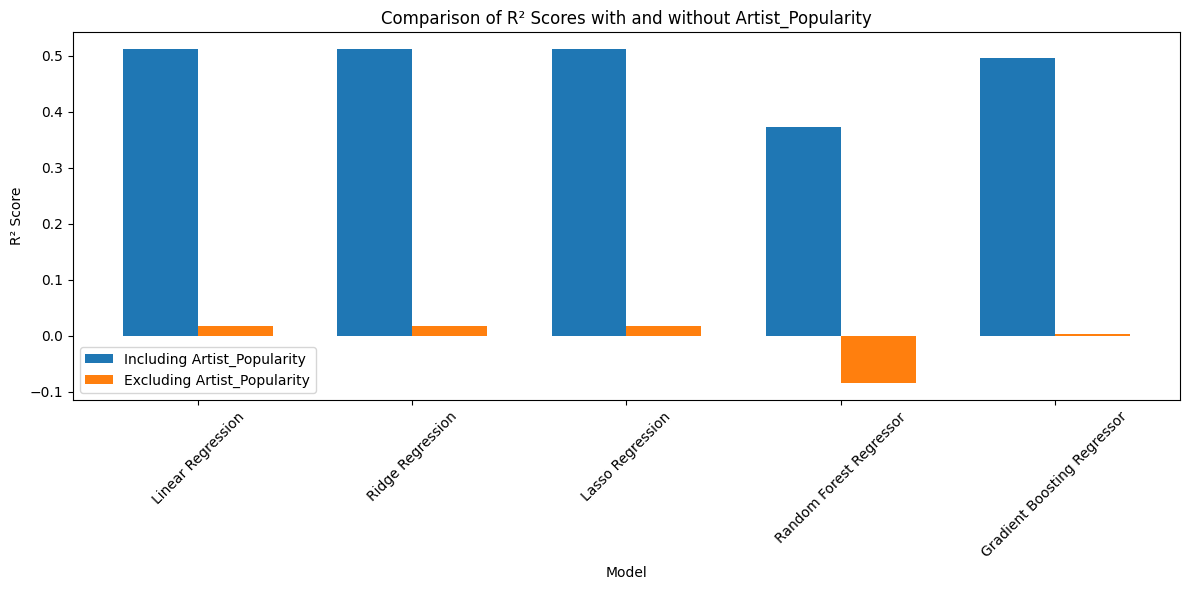

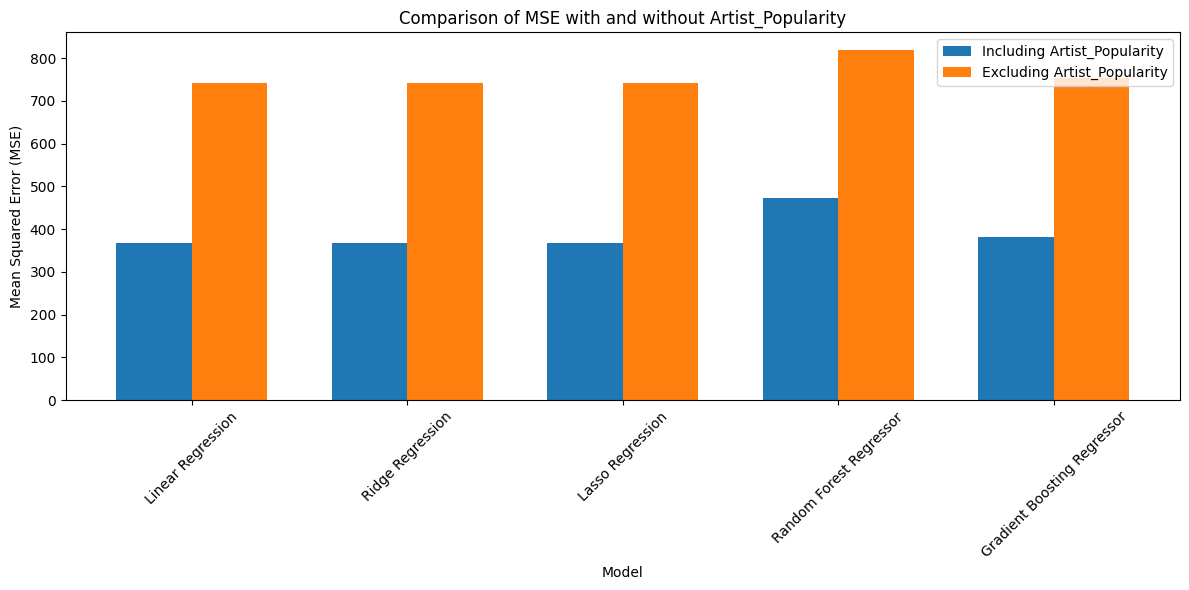

In [ ]:
# Assuming df1 is already loaded with data in previous codeblocks

# ------------------------------- Handle Missing Values (Numerical Features) -------------------------------

# List of numerical features
numerical_features = [
    'Danceability', 'Energy', 'Acousticness', 'Instrumentalness',
    'Valence', 'Speechiness', 'Liveness', 'Tempo', 'Loudness', 'Popularity'
]

# Fill missing numerical features with median values
for column in numerical_features:
    if df1[column].isnull().any():
        median_value = df1[column].median()
        df1[column].fillna(median_value, inplace=True)
        print(f"Filled missing values in '{column}' with median value: {median_value}")

# Verify no missing values remain in numerical features
print("\nMissing Values After Imputation (Numerical Features):")
print(df1[numerical_features].isnull().sum())

# ------------------------------- Handle Missing Values in 'Album Release Date' -------------------------------

# Convert 'Album Release Date' to datetime, coerce errors to NaT
df1['Album Release Date'] = pd.to_datetime(df1['Album Release Date'], errors='coerce')

# Impute missing 'Album Release Date' with median date
median_release_date = df1['Album Release Date'].median()
df1['Album Release Date'].fillna(median_release_date, inplace=True)
print(f"\nFilled missing 'Album Release Date' with median date: {median_release_date}")

# Extract 'Release_Year' and 'Age_of_Song'
current_year = 2024  # Update as needed
df1['Release_Year'] = df1['Album Release Date'].dt.year
df1['Age_of_Song'] = current_year - df1['Release_Year']

# Verify no missing values remain in 'Release_Year' and 'Age_of_Song'
print("\nMissing Values After Imputation (Release Date Features):")
print(df1[['Release_Year', 'Age_of_Song']].isnull().sum())

# ------------------------------ Handle Missing Values in Categorical Features ------------------------------

# Fill missing 'Track Name' and 'Artist Name(s)' with placeholder
df1['Track Name'].fillna('Unknown Track', inplace=True)
df1['Artist Name(s)'].fillna('Unknown Artist', inplace=True)

# Fill missing 'Artist Genres' with 'Unknown'
df1['Artist Genres'].fillna('Unknown', inplace=True)

# Fill missing 'Label' with 'Unknown'
df1['Label'].fillna('Unknown', inplace=True)

# ------------------------------- Feature Engineering -------------------------------------------

## a. Genre Features

# Extract Primary Genre
df1['Primary Genre'] = df1['Artist Genres'].apply(
    lambda x: x.split(',')[0].strip() if x != 'Unknown' else 'Unknown'
)

# Aggregate rare genres into 'Other'
genre_counts = df1['Primary Genre'].value_counts()
threshold = 10  # Define threshold for rare genres
rare_genres = genre_counts[genre_counts < threshold].index
df1['Primary Genre'] = df1['Primary Genre'].apply(
    lambda x: 'Other' if x in rare_genres else x
)

# One-Hot Encode 'Primary Genre' with prefix
genre_dummies = pd.get_dummies(df1['Primary Genre'], prefix='Genre')

# Limit the number of dummy variables to top N genres
top_n_genres = 10
top_genres = genre_counts.nlargest(top_n_genres).index

# Create a list of column names with 'Genre_' prefix
top_genres_columns = [f"Genre_{genre}" for genre in top_genres]

# Keep only the top genre columns that exist in genre_dummies
existing_top_genres_columns = [col for col in top_genres_columns if col in genre_dummies.columns]
genre_dummies = genre_dummies[existing_top_genres_columns]

# Create 'Genre_Other' column to capture genres not in top_genres
df1['Genre_Other'] = df1['Primary Genre'].apply(lambda x: 1 if x not in top_genres else 0)

# Concatenate the dummy variables and 'Genre_Other' to the main dataframe
df1 = pd.concat([df1, genre_dummies, df1['Genre_Other']], axis=1)

# Drop the original 'Primary Genre' column
df1.drop(['Primary Genre'], axis=1, inplace=True)

## b. Artist Popularity Proxy

# Extract primary artist name
df1['Primary Artist'] = df1['Artist Name(s)'].astype(str).apply(lambda x: x.split(',')[0].strip())

# Calculate mean popularity per artist
artist_popularity = df1.groupby('Primary Artist')['Popularity'].mean().reset_index()
artist_popularity.rename(columns={'Popularity': 'Artist_Popularity'}, inplace=True)

# Merge back to the main dataframe
df1 = pd.merge(df1, artist_popularity, on='Primary Artist', how='left')

# Handle any missing 'Artist_Popularity'
df1['Artist_Popularity'].fillna(df1['Artist_Popularity'].median(), inplace=True)

## c. Marketing Efforts Proxy

# Define major labels (example list; modify based on actual data)
major_labels = ['Sony Music', 'Universal Music', 'Warner Music', 'EMI', 'BMG']

# Create a binary feature: Major_Label (1) if label is major, else 0
df1['Major_Label'] = df1['Label'].apply(lambda x: 1 if x in major_labels else 0)

## d. Explicit Content

# Ensure 'Explicit' is binary (0 or 1)
df1['Explicit'] = df1['Explicit'].apply(lambda x: 1 if x == 1 else 0)

## e. Track Duration in Seconds

# Convert Track Duration from milliseconds to seconds
df1['Duration_Sec'] = df1['Track Duration (ms)'] / 1000

## f. Interaction Features

# Interaction between Energy and Valence
df1['energy_valence_interaction'] = df1['Energy'] * df1['Valence']

# Interaction between Danceability and Energy
df1['dance_energy_interaction'] = df1['Danceability'] * df1['Energy']

## g. Binning Continuous Variables

# Tempo Binning
def tempo_binning(tempo):
    if tempo < 90:
        return 'Slow'
    elif 90 <= tempo <= 120:
        return 'Moderate'
    else:
        return 'Fast'

df1['tempo_binned'] = df1['Tempo'].apply(tempo_binning)

# Duration Binning
def duration_binning(duration_sec):
    if duration_sec < 180:
        return 'Short'
    elif 180 <= duration_sec <= 240:
        return 'Medium'
    else:
        return 'Long'

df1['duration_binned'] = df1['Duration_Sec'].apply(duration_binning)

# One-Hot Encode the binned features
tempo_dummies = pd.get_dummies(df1['tempo_binned'], prefix='tempo')
duration_dummies = pd.get_dummies(df1['duration_binned'], prefix='duration')

# Concatenate the dummy variables with the main dataframe
df1 = pd.concat([df1, tempo_dummies, duration_dummies], axis=1)

# Drop the original binned columns
df1.drop(['tempo_binned', 'duration_binned'], axis=1, inplace=True)

## h. Overall Mood Score

# Overall Mood Score
df1['overall_mood'] = df1['Valence'] * df1['Energy']

## i. Binary Instrumentalness

df1['is_instrumental'] = df1['Instrumentalness'].apply(lambda x: 1 if x > 0.5 else 0)

# Drop original 'Instrumentalness' if desired
df1.drop(['Instrumentalness'], axis=1, inplace=True)


# ------------------------------- Prepare Features and Target Variable -------------------------------

# Features including 'Artist_Popularity'
features_including_popularity = [
    'Danceability', 'Energy', 'Acousticness',
    'Valence', 'Speechiness', 'Liveness',
    'Loudness', 'Age_of_Song',
    'Major_Label', 'Explicit',
    'energy_valence_interaction', 'dance_energy_interaction',
    'overall_mood', 'is_instrumental', # Use 'is_instrumental' instead of 'Instrumentalness'
    'Genre_Other',  # Ensure 'Genre_Other' is included
    'Artist_Popularity',
#    'Duration_Sec',
#    'Tempo',
]

# Include genre dummy variables
genre_columns = [col for col in df1.columns if col.startswith('Genre_')]
features_including_popularity += genre_columns

# Include tempo and duration dummies
tempo_columns = [col for col in df1.columns if col.startswith('tempo_')]
duration_columns = [col for col in df1.columns if col.startswith('duration_')]
features_including_popularity.extend(tempo_columns)
features_including_popularity.extend(duration_columns)

# Finalize features and target
X_including_popularity = df1[features_including_popularity]
y = df1['Popularity']

# Features excluding 'Artist_Popularity'
features_excluding_popularity = [
    'Danceability', 'Energy', 'Acousticness',
    'Valence', 'Speechiness', 'Liveness',
    'Loudness', 'Age_of_Song', 'Major_Label',
    'Explicit',
    'energy_valence_interaction', 'dance_energy_interaction',
    'overall_mood', 'is_instrumental',
    'Genre_Other',
]

# Add genre columns to features
features_excluding_popularity += genre_columns

# Include tempo and duration dummies
tempo_columns = [col for col in df1.columns if col.startswith('tempo_')]
duration_columns = [col for col in df1.columns if col.startswith('duration_')]
features_excluding_popularity.extend(tempo_columns)
features_excluding_popularity.extend(duration_columns)

# Finalize features and target
X_excluding_popularity = df1[features_excluding_popularity]

# ------------------------------- Feature Scaling -------------------------------

# Including 'Artist_Popularity'
scaler_including = StandardScaler()
X_scaled_including = scaler_including.fit_transform(X_including_popularity)
# Fix: Create DataFrame using the correct columns from X_including_popularity
X_scaled_df_including = pd.DataFrame(X_scaled_including, columns=X_including_popularity.columns)

# Excluding 'Artist_Popularity'
scaler_excluding = StandardScaler()
X_scaled_excluding = scaler_excluding.fit_transform(X_excluding_popularity)
# Fix: Create DataFrame using the correct columns from X_excluding_popularity
X_scaled_df_excluding = pd.DataFrame(X_scaled_excluding, columns=X_excluding_popularity.columns)

# ------------------------------- Split the Data -------------------------------

# Including 'Artist_Popularity'
X_train_including, X_test_including, y_train_including, y_test_including = train_test_split(
    X_scaled_df_including, y, test_size=0.2, random_state=48
)

# Excluding 'Artist_Popularity'
X_train_excluding, X_test_excluding, y_train_excluding, y_test_excluding = train_test_split(
    X_scaled_df_excluding, y, test_size=0.2, random_state=48
)

# ------------------------------- Address Multicollinearity with VIF -------------------------------

def calculate_vif(df):
    """
    Calculate Variance Inflation Factor (VIF) for each feature in the DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the features.

    Returns:
    - vif (pd.DataFrame): DataFrame containing features and their corresponding VIF values.
    """
    X_const = add_constant(df)
    vif = pd.DataFrame()
    vif["Feature"] = X_const.columns
    vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
    return vif

# Including 'Artist_Popularity'
vif_data_including = calculate_vif(X_train_including)
features_to_drop_including = vif_data_including[vif_data_including['VIF'] > 5]['Feature'].tolist()
if 'const' in features_to_drop_including:
    features_to_drop_including.remove('const')
features_final_including = [feature for feature in features_including_popularity if feature not in features_to_drop_including]

X_train_final_including = X_train_including[features_final_including]
X_test_final_including = X_test_including[features_final_including]

# Excluding 'Artist_Popularity'
vif_data_excluding = calculate_vif(X_train_excluding)
features_to_drop_excluding = vif_data_excluding[vif_data_excluding['VIF'] > 5]['Feature'].tolist()
if 'const' in features_to_drop_excluding:
    features_to_drop_excluding.remove('const')
features_final_excluding = [feature for feature in features_excluding_popularity if feature not in features_to_drop_excluding]

X_train_final_excluding = X_train_excluding[features_final_excluding]
X_test_final_excluding = X_test_excluding[features_final_excluding]

# ------------------------------- Train and Evaluate Models -------------------------------

def train_and_evaluate_models(X_train, X_test, y_train, y_test, context):
    """
    Train and evaluate multiple regression models.

    Parameters:
    - X_train (pd.DataFrame): Training features.
    - X_test (pd.DataFrame): Testing features.
    - y_train (pd.Series): Training target variable.
    - y_test (pd.Series): Testing target variable.
    - context (str): Description of the feature set (e.g., including or excluding Artist_Popularity).

    Returns:
    - results (dict): Dictionary containing model performance metrics and predictions.
    """
    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=25),
        'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, random_state=25)
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f'\n{name} {context} - MSE: {mse:.2f}, R²: {r2:.4f}')
        results[name] = {
            'MSE': mse,
            'R2': r2,
            'Predictions': y_pred,
            'Model': model
        }

    return results

# Including 'Artist_Popularity'
print("\n--- Modeling with Artist_Popularity ---\n")
results_including = train_and_evaluate_models(
    X_train_final_including, X_test_final_including,
    y_train_including, y_test_including,
    context="(Including Artist_Popularity)"
)

# Excluding 'Artist_Popularity'
print("\n--- Modeling without Artist_Popularity ---\n")
results_excluding = train_and_evaluate_models(
    X_train_final_excluding, X_test_final_excluding,
    y_train_excluding, y_test_excluding,
    context="(Excluding Artist_Popularity)"
)

# ------------------------------- Cross-Validation for Linear Regression -------------------------------

# Including 'Artist_Popularity'
cv_scores_including = cross_val_score(
    results_including['Linear Regression']['Model'],
    X_train_final_including, y_train_including, cv=5, scoring='r2'
)
print(f'\nCross-Validation R² Scores for Linear Regression (Including Artist_Popularity): {cv_scores_including}')
print(f'Mean Cross-Validation R²: {cv_scores_including.mean():.4f}')

# Excluding 'Artist_Popularity'
cv_scores_excluding = cross_val_score(
    results_excluding['Linear Regression']['Model'],
    X_train_final_excluding, y_train_excluding, cv=5, scoring='r2'
)
print(f'\nCross-Validation R² Scores for Linear Regression (Excluding Artist_Popularity): {cv_scores_excluding}')
print(f'Mean Cross-Validation R²: {cv_scores_excluding.mean():.4f}')

# ------------------------------- Residual Analysis for Linear Regression -------------------------------

# Including 'Artist_Popularity'
residuals_including = y_test_including - results_including['Linear Regression']['Predictions']

plt.figure(figsize=(10, 6))
sns.scatterplot(x=results_including['Linear Regression']['Predictions'], y=residuals_including, alpha=0.5, edgecolor='none')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values for Linear Regression (Including Artist_Popularity)')
plt.show()

# Excluding 'Artist_Popularity'
residuals_excluding = y_test_excluding - results_excluding['Linear Regression']['Predictions']

plt.figure(figsize=(10, 6))
sns.scatterplot(x=results_excluding['Linear Regression']['Predictions'], y=residuals_excluding, alpha=0.5, edgecolor='none')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values for Linear Regression (Excluding Artist_Popularity)')
plt.show()

# ------------------------------- Feature Importance from Random Forest -------------------------------

# Including 'Artist_Popularity'
importances_including = results_including['Random Forest Regressor']['Model'].feature_importances_
feature_importances_including = pd.DataFrame({
    'Feature': X_train_final_including.columns,
    'Importance': importances_including
}).sort_values(by='Importance', ascending=False)

print('\nFeature Importances from Random Forest Regressor (Including Artist_Popularity):')
print(feature_importances_including.head(20))

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', y='Feature',
    data=feature_importances_including.head(20),
    palette='viridis', dodge=False
)
plt.title('Top 20 Feature Importances (Including Artist_Popularity)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Excluding 'Artist_Popularity'
importances_excluding = results_excluding['Random Forest Regressor']['Model'].feature_importances_
feature_importances_excluding = pd.DataFrame({
    'Feature': X_train_final_excluding.columns,
    'Importance': importances_excluding
}).sort_values(by='Importance', ascending=False)

print('\nFeature Importances from Random Forest Regressor (Excluding Artist_Popularity):')
print(feature_importances_excluding.head(20))

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', y='Feature',
    data=feature_importances_excluding.head(20),
    palette='viridis', dodge=False
)
plt.title('Top 20 Feature Importances (Excluding Artist_Popularity)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# ------------------------------- Visualization of Actual vs Predicted Values -------------------------------

def plot_actual_vs_predicted(y_test, results_dict, context):
    """
    Plot Actual vs Predicted Popularity for multiple models.

    Parameters:
    - y_test (pd.Series): Actual popularity values.
    - results_dict (dict): Dictionary containing model predictions.
    - context (str): Description of the feature set.
    """
    model_predictions = {k: v['Predictions'] for k, v in results_dict.items()}
    models = list(model_predictions.keys())
    num_models = len(models)
    cols = 2
    rows = (num_models + 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
    axes = axes.flatten()

    for idx, (model_name, y_pred) in enumerate(model_predictions.items()):
        ax = axes[idx]
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, ax=ax, edgecolor='none')
        ax.set_xlabel('Actual Popularity')
        ax.set_ylabel('Predicted Popularity')
        ax.set_title(f'{model_name} {context}')

        # Plot the y = x line for reference
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

        # Calculate and display R-squared on the plot
        r2 = r2_score(y_test, y_pred)
        ax.text(0.05, 0.95, f'$R^2$ = {r2:.2f}', transform=ax.transAxes,
                fontsize=12, verticalalignment='top')

    # Remove empty subplots
    for idx in range(len(model_predictions), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

# Plot for Models Including 'Artist_Popularity'
plot_actual_vs_predicted(y_test_including, results_including, context='(Including Artist_Popularity)')

# Plot for Models Excluding 'Artist_Popularity'
plot_actual_vs_predicted(y_test_excluding, results_excluding, context='(Excluding Artist_Popularity)')

# ------------------------------- Comparing the Results -------------------------------

# Create a summary DataFrame for comparison
comparison_metrics = pd.DataFrame({
    'Model': list(results_including.keys()),
    'MSE (Including Artist_Popularity)': [v['MSE'] for v in results_including.values()],
    'R² (Including Artist_Popularity)': [v['R2'] for v in results_including.values()],
    'MSE (Excluding Artist_Popularity)': [v['MSE'] for v in results_excluding.values()],
    'R² (Excluding Artist_Popularity)': [v['R2'] for v in results_excluding.values()]
})

print("\n--- Comparison of Models with and without Artist_Popularity ---\n")
print(comparison_metrics)

# Visual Comparison of R² Scores
plt.figure(figsize=(12, 6))
index = np.arange(len(comparison_metrics['Model']))
bar_width = 0.35

plt.bar(index, comparison_metrics['R² (Including Artist_Popularity)'], bar_width, label='Including Artist_Popularity')
plt.bar(index + bar_width, comparison_metrics['R² (Excluding Artist_Popularity)'], bar_width, label='Excluding Artist_Popularity')

plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Comparison of R² Scores with and without Artist_Popularity')
plt.xticks(index + bar_width / 2, comparison_metrics['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Visual Comparison of MSE
plt.figure(figsize=(12, 6))
index = np.arange(len(comparison_metrics['Model']))
bar_width = 0.35

plt.bar(index, comparison_metrics['MSE (Including Artist_Popularity)'], bar_width, label='Including Artist_Popularity')
plt.bar(index + bar_width, comparison_metrics['MSE (Excluding Artist_Popularity)'], bar_width, label='Excluding Artist_Popularity')

plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE with and without Artist_Popularity')
plt.xticks(index + bar_width / 2, comparison_metrics['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Check for exact matches of "Taylor Swift" in the 'Artist Name(s)' column. Verification dataset is intact.
taylor_present_exact = df1['Artist Name(s)'].str.lower().str.strip().eq('taylor swift').any()

if taylor_present_exact:
    print("Taylor Swift is present in the dataset (exact match).")
else:
    print("Taylor Swift is NOT present in the dataset (exact match).")

df1.info()

Taylor Swift is present in the dataset (exact match).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9953 entries, 0 to 9952
Data columns (total 66 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Track URI                   9953 non-null   object        
 1   Track Name                  9953 non-null   object        
 2   Artist URI(s)               9951 non-null   object        
 3   Artist Name(s)              9953 non-null   object        
 4   Album URI                   9951 non-null   object        
 5   Album Name                  9951 non-null   object        
 6   Album Artist URI(s)         9951 non-null   object        
 7   Album Artist Name(s)        9951 non-null   object        
 8   Album Release Date          9953 non-null   datetime64[ns]
 9   Album Image URL             9949 non-null   object        
 10  Disc Number                 9953 non-null   int64         
 11  Tr

Number of features including Artist_Popularity: 34
Features including Artist_Popularity:
['Danceability', 'Energy', 'Acousticness', 'Valence', 'Speechiness', 'Liveness', 'Loudness', 'Age_of_Song', 'Major_Label', 'Explicit', 'energy_valence_interaction', 'dance_energy_interaction', 'overall_mood', 'is_instrumental', 'Genre_Other', 'Artist_Popularity', 'Genre_Other', 'Genre_dance pop', 'Genre_album rock', 'Genre_pop', 'Genre_Unknown', 'Genre_adult standards', 'Genre_australian rock', 'Genre_australian pop', 'Genre_alternative metal', 'Genre_australian dance', 'Genre_boy band', 'Genre_Other', 'tempo_Fast', 'tempo_Moderate', 'tempo_Slow', 'duration_Long', 'duration_Medium', 'duration_Short']
All features are present in df1.
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1183.3925 - mean_squared_error: 1183.3925 - val_loss: 430.3770 - val_mean_squared_error: 430.3770
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 390.2535 - mean_squared_error: 390.2535 - val_loss: 

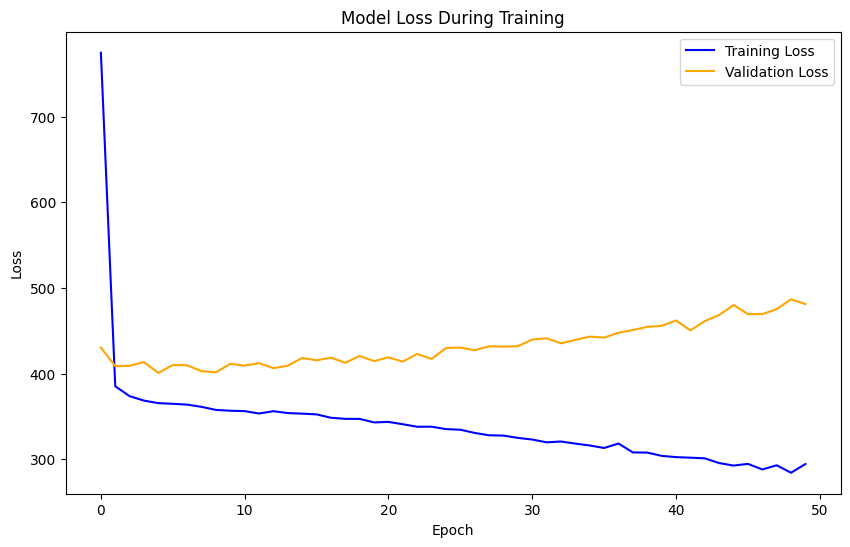

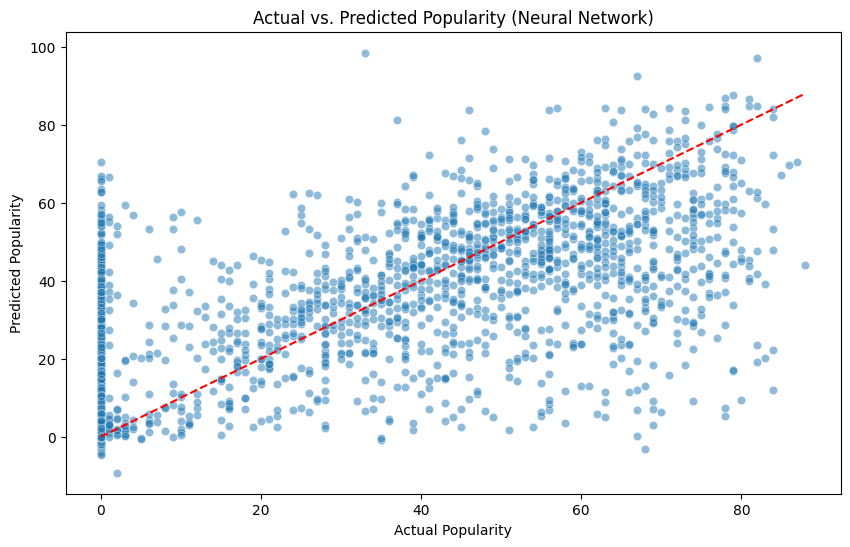

In [ ]:
# ------------- Neural Network Implementation ---------------
# keras sequential deep learning model.
# Simple to build a neural network model step by step.

# Identify the dummy variable column names
genre_columns = [col for col in df1.columns if col.startswith('Genre_')]
tempo_columns = [col for col in df1.columns if col.startswith('tempo_')]
duration_columns = [col for col in df1.columns if col.startswith('duration_')]

# Features including 'Artist_Popularity'
features_including_popularity = [
    'Danceability', 'Energy', 'Acousticness',
    'Valence', 'Speechiness', 'Liveness',
    'Loudness', 'Age_of_Song',
    'Major_Label', 'Explicit',
    'energy_valence_interaction', 'dance_energy_interaction',
    'overall_mood', 'is_instrumental',
    'Genre_Other',
    'Artist_Popularity',
]

# Add genre, tempo, and duration dummy columns
features_including_popularity += genre_columns + tempo_columns + duration_columns

# Verify the feature list
print(f"Number of features including Artist_Popularity: {len(features_including_popularity)}")
print("Features including Artist_Popularity:")
print(features_including_popularity)

# Check for duplicates
if len(features_including_popularity) != len(set(features_including_popularity)):
    print("Warning: There are duplicate features in the feature list.")
else:
    print("No duplicate features found.")

# Ensure all features exist in df1
missing_features = [feature for feature in features_including_popularity if feature not in df1.columns]
if missing_features:
    print(f"Missing features in df1: {missing_features}")
else:
    print("All features are present in df1.")

# Finalize features and target
X = df1[features_including_popularity]
y = df1['Popularity']

# Handle any missing values in features (if any)
X.fillna(0, inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=48
)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

# Train the model
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_mse = model.evaluate(X_test_scaled, y_test)
print(f"\nTest Mean Squared Error: {test_mse:.2f}")

# Predict on the test set
y_pred_nn = model.predict(X_test_scaled).flatten()

# Calculate R² Score
r2_nn = r2_score(y_test, y_pred_nn)
print(f"Neural Network R² Score: {r2_nn:.4f}")

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Scatter plot of actual vs predicted popularity
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_nn, alpha=0.5)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs. Predicted Popularity (Neural Network)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()


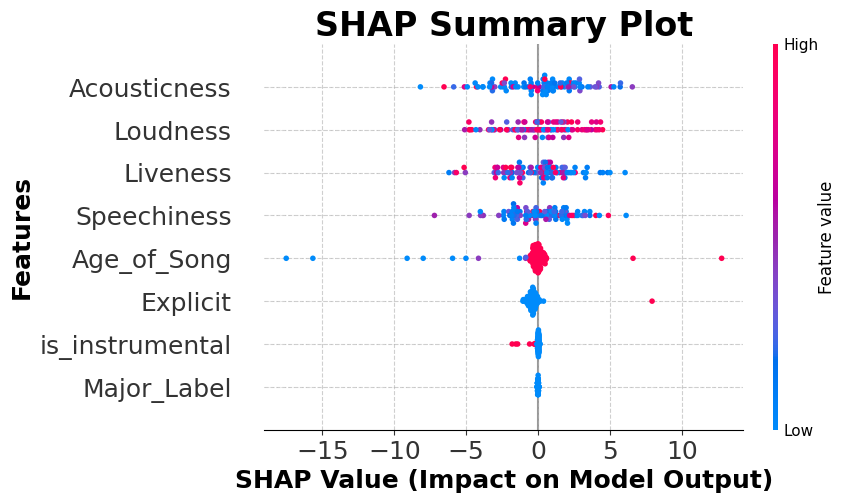


--- Comparison of Models ---

                                               Model         MSE        R²
0    Linear Regression (Including Artist_Popularity)  368.775770  0.511775
1     Ridge Regression (Including Artist_Popularity)  368.774116  0.511777
2     Lasso Regression (Including Artist_Popularity)  368.763228  0.511791
3  Random Forest Regressor (Including Artist_Popu...  473.253602  0.373456
4  Gradient Boosting Regressor (Including Artist_...  380.858059  0.495779
5    Linear Regression (Excluding Artist_Popularity)  741.838140  0.017874
6     Ridge Regression (Excluding Artist_Popularity)  741.838550  0.017874
7     Lasso Regression (Excluding Artist_Popularity)  742.309766  0.017250
8  Random Forest Regressor (Excluding Artist_Popu...  819.577431 -0.085045
9  Gradient Boosting Regressor (Excluding Artist_...  752.833448  0.003318


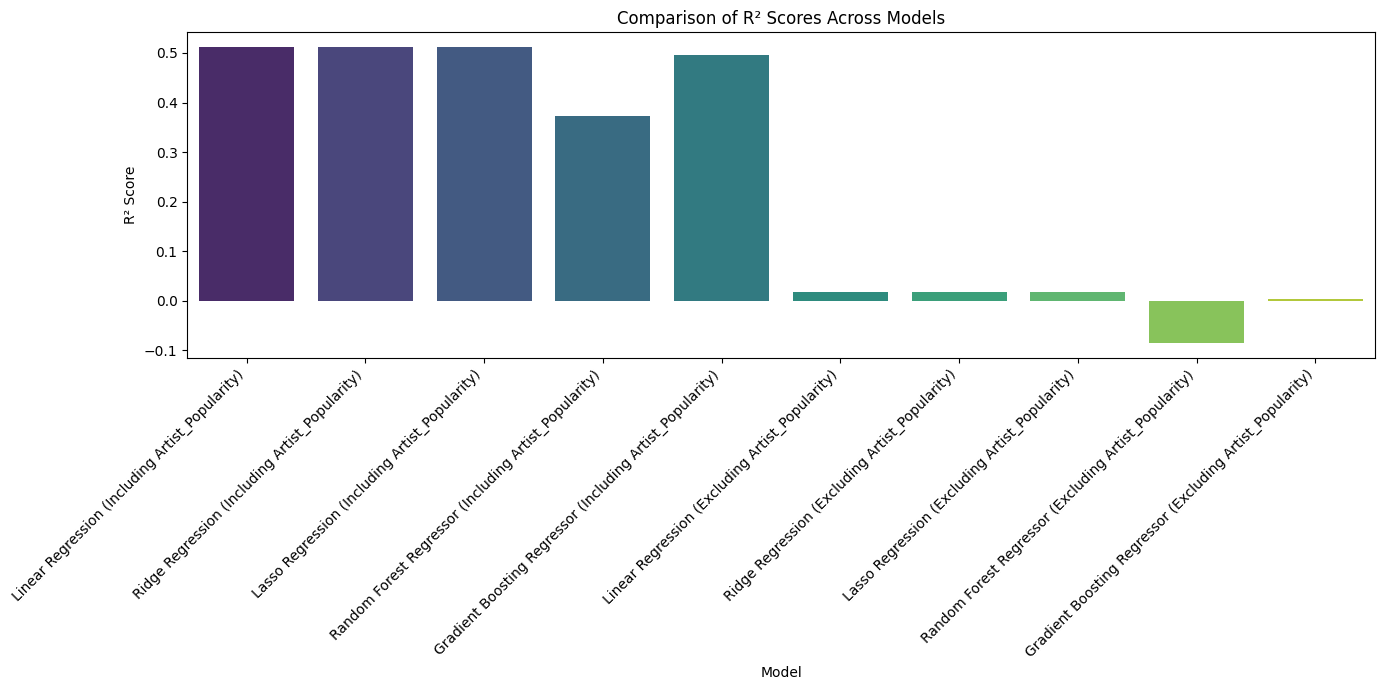

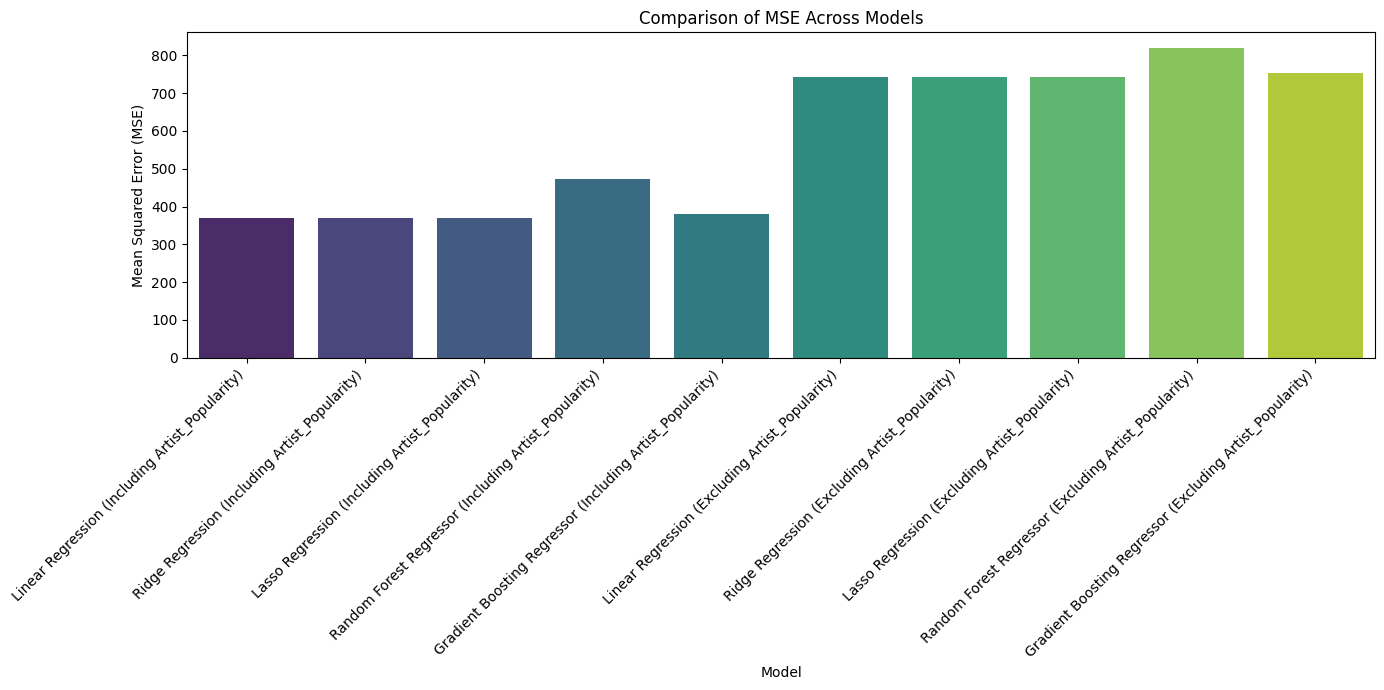

In [ ]:
shap.initjs()

# ------------------------------- SHAP Analysis for Random Forest Regressor (Excluding Artist_Popularity) -------------------------------

# Random Forest model trained without 'Artist_Popularity'
rf_model_excluding = results_excluding['Random Forest Regressor']['Model']

# Use the scaled test data for SHAP values
X_test_sample = X_test_final_excluding.sample(n=100, random_state=42)
y_test_sample = y_test_excluding.loc[X_test_sample.index]

# Create the SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(rf_model_excluding)
shap_values = explainer.shap_values(X_test_sample)

# Get the feature names
feature_names = X_test_final_excluding.columns
X_test_sample_df = pd.DataFrame(X_test_sample, columns=feature_names)

# Scale and customize the SHAP summary plot
plt.figure(figsize=(20, 12))  # Adjust the figure size
shap.summary_plot(
    shap_values,
    X_test_sample_df,
    feature_names=feature_names,
    show=False  # Prevent SHAP from immediately displaying the plot
)

# Customize the plot's font sizes
plt.title("SHAP Summary Plot", fontsize=24, fontweight='bold')
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=18, fontweight='bold')
plt.ylabel("Features", fontsize=18, fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Save the figure as a high-resolution image
plt.savefig("poster_shap_summary.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()
# ----------------------------------- Comparing with Previous Models ---------------------------------

# Create a summary DataFrame for comparison

# For models including 'Artist_Popularity'
comparison_metrics_including = pd.DataFrame({
    'Model': [
        'Linear Regression (Including Artist_Popularity)',
        'Ridge Regression (Including Artist_Popularity)',
        'Lasso Regression (Including Artist_Popularity)',
        'Random Forest Regressor (Including Artist_Popularity)',
        'Gradient Boosting Regressor (Including Artist_Popularity)'
    ],
    'MSE': [
        results_including['Linear Regression']['MSE'],
        results_including['Ridge Regression']['MSE'],
        results_including['Lasso Regression']['MSE'],
        results_including['Random Forest Regressor']['MSE'],
        results_including['Gradient Boosting Regressor']['MSE']
    ],
    'R²': [
        results_including['Linear Regression']['R2'],
        results_including['Ridge Regression']['R2'],
        results_including['Lasso Regression']['R2'],
        results_including['Random Forest Regressor']['R2'],
        results_including['Gradient Boosting Regressor']['R2']
    ]
})

# For models excluding 'Artist_Popularity'
comparison_metrics_excluding = pd.DataFrame({
    'Model': [
        'Linear Regression (Excluding Artist_Popularity)',
        'Ridge Regression (Excluding Artist_Popularity)',
        'Lasso Regression (Excluding Artist_Popularity)',
        'Random Forest Regressor (Excluding Artist_Popularity)',
        'Gradient Boosting Regressor (Excluding Artist_Popularity)'
    ],
    'MSE': [
        results_excluding['Linear Regression']['MSE'],
        results_excluding['Ridge Regression']['MSE'],
        results_excluding['Lasso Regression']['MSE'],
        results_excluding['Random Forest Regressor']['MSE'],
        results_excluding['Gradient Boosting Regressor']['MSE']
    ],
    'R²': [
        results_excluding['Linear Regression']['R2'],
        results_excluding['Ridge Regression']['R2'],
        results_excluding['Lasso Regression']['R2'],
        results_excluding['Random Forest Regressor']['R2'],
        results_excluding['Gradient Boosting Regressor']['R2']
    ]
})

# Combine both DataFrames
comparison_metrics_total = pd.concat([comparison_metrics_including, comparison_metrics_excluding], ignore_index=True)

print("\n--- Comparison of Models ---\n")
print(comparison_metrics_total)

# Visual Comparison of R² Scores
plt.figure(figsize=(14, 7))
sns.barplot(x='Model', y='R²', data=comparison_metrics_total, palette='viridis')
plt.title('Comparison of R² Scores Across Models')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visual Comparison of MSE
plt.figure(figsize=(14, 7))
sns.barplot(x='Model', y='MSE', data=comparison_metrics_total, palette='viridis')
plt.title('Comparison of MSE Across Models')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Check for exact matches of "Taylor Swift" in the 'Artist Name(s)' column. Verification dataset is intact.
taylor_present_exact = df1['Artist Name(s)'].str.lower().str.strip().eq('taylor swift').any()

if taylor_present_exact:
    print("Taylor Swift is present in the dataset (exact match).")
else:
    print("Taylor Swift is NOT present in the dataset (exact match).")

df1.info()

Taylor Swift is present in the dataset (exact match).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9953 entries, 0 to 9952
Data columns (total 66 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Track URI                   9953 non-null   object        
 1   Track Name                  9953 non-null   object        
 2   Artist URI(s)               9951 non-null   object        
 3   Artist Name(s)              9953 non-null   object        
 4   Album URI                   9951 non-null   object        
 5   Album Name                  9951 non-null   object        
 6   Album Artist URI(s)         9951 non-null   object        
 7   Album Artist Name(s)        9951 non-null   object        
 8   Album Release Date          9953 non-null   datetime64[ns]
 9   Album Image URL             9949 non-null   object        
 10  Disc Number                 9953 non-null   int64         
 11  Tr

In [ ]:
# Recommender system base final implementation

from fuzzywuzzy import fuzz, process

# Identify the dummy variable column names
genre_columns = [col for col in df1.columns if col.startswith('Genre_')]
tempo_columns = [col for col in df1.columns if col.startswith('tempo_')]
duration_columns = [col for col in df1.columns if col.startswith('duration_')]

# Features including 'Artist_Popularity'
features = [
    'Danceability', 'Energy', 'Acousticness',
    'Valence', 'Speechiness', 'Liveness',
    'Loudness', 'Age_of_Song',
    'Major_Label', 'Explicit',
    'energy_valence_interaction', 'dance_energy_interaction',
    'overall_mood', 'is_instrumental',
    'Genre_Other',
    'Artist_Popularity',
]

# Add genre, tempo, and duration dummy columns
features += genre_columns + tempo_columns + duration_columns

# Extract features and target
X = df1[features]
y = df1['Popularity']

# Feature Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(X)

# -------------------------------Recommend Similar Songs Function-------------------------------

def recommend_similar_songs(top_n=10, score_threshold=75):
    """
    Recommend similar songs based on user input using fuzzy matching and Euclidean distance.

    Parameters:
    - top_n (int): Number of similar songs to recommend.
    - score_threshold (int): Minimum score for fuzzy matching (0-100).

    Returns:
    - recommended_songs (pd.DataFrame): DataFrame of recommended songs.
    """
    # Ask user for song name (required) and artist name (optional)
    while True:
        song_name_input = input("Enter the name of the song (required): ").strip()
        if song_name_input:
            break
        else:
            print("Song name cannot be empty. Please enter a valid song name.")

    artist_name_input = input("Enter the artist name (optional): ").strip()

    # Ask user for number of recommendations
    while True:
        try:
            top_n_input = input(f"Enter the number of recommendations you want (default {top_n}): ").strip()
            top_n = int(top_n_input) if top_n_input else top_n
            if top_n > 0:
                break
            else:
                print("Please enter a positive integer for the number of recommendations.")
        except ValueError:
            print("Invalid input. Please enter a valid integer for the number of recommendations.")

    # Initialize variables
    matched_song_name = None
    matched_artist_name = None
    song_indices = []

    # Fuzzy matching for song name
    song_names = df1['Track Name'].unique()
    song_match = process.extractOne(song_name_input, song_names, scorer=fuzz.token_sort_ratio, score_cutoff=score_threshold)

    if song_match:
        matched_song_name = song_match[0]
        print(f"\nMatched Song: '{matched_song_name}' with score {song_match[1]}")
        # Get all indices of the matched song
        song_indices = df1[df1['Track Name'] == matched_song_name].index.tolist()
    else:
        print(f"\nNo close match found for the song '{song_name_input}'.")
        if not artist_name_input:
            print("Since no artist name is provided, cannot proceed with recommendations.")
            return pd.DataFrame()  # Exit if no artist name provided

    # Fuzzy matching for artist name if provided
    if artist_name_input:
        artist_names = df1['Primary Artist'].unique()
        artist_match = process.extractOne(artist_name_input, artist_names, scorer=fuzz.token_sort_ratio, score_cutoff=score_threshold)

        if artist_match:
            matched_artist_name = artist_match[0]
            print(f"Matched Artist: '{matched_artist_name}' with score {artist_match[1]}")
            if song_indices:
                # Filter songs by matched song name and matched artist name
                song_indices = df1[
                    (df1['Track Name'] == matched_song_name) &
                    (df1['Primary Artist'] == matched_artist_name)
                ].index.tolist()
                if not song_indices:
                    print(f"No songs found for '{matched_song_name}' by '{matched_artist_name}'.")
                    return pd.DataFrame()
            else:
                # Get all song indices for the matched artist
                song_indices = df1[df1['Primary Artist'] == matched_artist_name].index.tolist()
        else:
            print(f"No close match found for the artist '{artist_name_input}'.")
            if not song_name_input:
                print("Since no song name is provided, cannot proceed with recommendations.")
                return pd.DataFrame()  # Exit if no song name provided

    # Aggregate all relevant song indices based on inputs
    if song_indices:
        # If both song and artist are matched
        if matched_song_name and matched_artist_name:
            print(f"\nUsing songs by '{matched_artist_name}' titled '{matched_song_name}' for recommendations.")
        elif matched_song_name:
            print(f"\nUsing songs titled '{matched_song_name}' for recommendations.")
        elif matched_artist_name:
            print(f"\nUsing songs by '{matched_artist_name}' for recommendations.")
    else:
        # If no specific song or artist matched, consider all songs
        print("\nProceeding with recommendations based on the entire dataset.")
        song_indices = list(range(len(df1)))

    # If multiple songs are matched (e.g., multiple songs by the same artist), average their feature vectors
    if len(song_indices) > 1:
        song_feature_vectors = features_scaled[song_indices]
        song_feature_vector = np.mean(song_feature_vectors, axis=0)
    elif len(song_indices) == 1:
        song_feature_vector = features_scaled[song_indices[0]]
    else:
        print("No songs found for the given inputs.")
        return pd.DataFrame()

    # Compute Euclidean distances
    distances = np.linalg.norm(features_scaled - song_feature_vector, axis=1)
    similar_song_indices = np.argsort(distances)

    # Exclude the input songs from the recommendations
    if song_indices:
        similar_song_indices = [idx for idx in similar_song_indices if idx not in song_indices]

    # Ensure indices are within bounds
    similar_song_indices = [i for i in similar_song_indices if 0 <= i < len(df1)]

    # Get top N recommendations
    top_indices = similar_song_indices[:top_n]

    # Retrieve song details
    recommended_songs = df1.iloc[top_indices][['Track Name', 'Artist Name(s)', 'Album Name']]

    # Display recommendations
    if not recommended_songs.empty:
        print(f"\nRecommended Songs (Top {top_n}):")
        for idx, row in recommended_songs.iterrows():
            print(f"- '{row['Track Name']}' by {row['Artist Name(s)']} from the album '{row['Album Name']}'")
    else:
        print("\nNo recommendations found.")

    return recommended_songs

In [ ]:
# To use the recommender, simply call the function
recommend_similar_songs()

Enter the name of the song (required): juda
Enter the artist name (optional): layd gag
Enter the number of recommendations you want (default 10): 15

Matched Song: 'Judas' with score 89
Matched Artist: 'Lady Gaga' with score 82

Using songs by 'Lady Gaga' titled 'Judas' for recommendations.

Recommended Songs (Top 15):
- 'It's Raining Men' by Geri Halliwell from the album 'Scream If You Wanna Go Faster'
- 'Things We Lost In The Fire' by Bastille from the album 'Bad Blood'
- 'Where Have You Been' by Rihanna from the album 'Talk That Talk'
- 'Red Lights' by Tiësto from the album 'A Town Called Paradise'
- 'Red Lights' by Tiësto from the album 'A Town Called Paradise'
- 'Where Have You Been' by Rihanna from the album 'Talk That Talk (Deluxe)'
- 'Where Have You Been' by Rihanna from the album 'Talk That Talk'
- '65 Mustang' by Five For Fighting from the album 'Two Lights'
- 'Black Fingernails, Red Wine' by Eskimo Joe from the album 'Black Fingernails, Red Wine'
- 'Dancing In the Dark' by B

Track Name        Artist Name(s)  \
8926                    It's Raining Men        Geri Halliwell   
9020          Things We Lost In The Fire              Bastille   
5254                 Where Have You Been               Rihanna   
1201                          Red Lights                Tiësto   
1297                          Red Lights                Tiësto   
808                  Where Have You Been               Rihanna   
5896                 Where Have You Been               Rihanna   
9443                          65 Mustang     Five For Fighting   
8930         Black Fingernails, Red Wine            Eskimo Joe   
4076                 Dancing In the Dark     Bruce Springsteen   
6548                          Fairground            Simply Red   
9867                       Coming of Age     Foster The People   
4798                  The Boys Of Summer  DJ Sammy, Loona, Mel   
2335  The Boys Of Summer - Radio Version              DJ Sammy   
8315            Rapture (feat.Nadia Ali)        iio, Nadia Ali   

                                           Album Name  
8926                    Scream If You Wanna Go Faster  
9020                                        Bad Blood  
5254                                   Talk That Talk  
1201                           A Town Called Paradise  
1297                           A Town Called Paradise  
808                           Talk That Talk (Deluxe)  
5896                                   Talk That Talk  
9443                                       Two Lights  
8930                      Black Fingernails, Red Wine  
4076                               Born In The U.S.A.  
6548  Big Love Greatest Hits Edition 30th Anniversary  
9867                                       Supermodel  
4798                                           Heaven  
2335                               The Boys of Summer  
8315                        Poetica (feat. Nadia Ali)

In [ ]:
# Check for exact matches of "Taylor Swift" in the 'Artist Name(s)' column. Verification dataset is intact.
taylor_present_exact = df1['Artist Name(s)'].str.lower().str.strip().eq('taylor swift').any()

if taylor_present_exact:
    print("Taylor Swift is present in the dataset (exact match).")
else:
    print("Taylor Swift is NOT present in the dataset (exact match).")

df1.info()


Taylor Swift is present in the dataset (exact match).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9953 entries, 0 to 9952
Data columns (total 66 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Track URI                   9953 non-null   object        
 1   Track Name                  9953 non-null   object        
 2   Artist URI(s)               9951 non-null   object        
 3   Artist Name(s)              9953 non-null   object        
 4   Album URI                   9951 non-null   object        
 5   Album Name                  9951 non-null   object        
 6   Album Artist URI(s)         9951 non-null   object        
 7   Album Artist Name(s)        9951 non-null   object        
 8   Album Release Date          9953 non-null   datetime64[ns]
 9   Album Image URL             9949 non-null   object        
 10  Disc Number                 9953 non-null   int64         
 11  Tr

In [ ]:
import pandas as pd
from rapidfuzz import process, fuzz
import numpy as np
from multiprocessing import Pool, cpu_count
from functools import partial
import string
import warnings

# Fuzzy matching/Record Linkage used to merge df1 and df2 together so that it can be use as the dataset for sbert model

# Suppress any warnings for cleaner output
warnings.filterwarnings('ignore')

def preprocess_column(series):
    """
    Preprocess the specified pandas Series by lowercasing and stripping whitespace.
    """
    return series.astype(str).str.lower().str.strip()

def create_blocking_key(name, key_length=2):
    """
    Create a blocking key based on the first 'key_length' characters of the name.
    Non-alphabetic characters are ignored.
    """
    name = ''.join(filter(str.isalpha, name))  # Remove non-alphabetic characters
    return name[:key_length] if len(name) >= key_length else name

def match_songs(block_df2, unique_block_df1, threshold, limit):
    """
    Perform fuzzy matching for a subset (block) of df2 against df1.

    Args:
        block_df2: Subset of df2 DataFrame belonging to the current block.
        unique_block_df1: List of unique combined names from df1 in the current block.
        threshold: Minimum fuzzy matching score to consider a match.
        limit: Number of top matches to retrieve.

    Returns:
        DataFrame with matched records including the best match and score.
    """
    if not unique_block_df1:
        # No matches possible if df1 block is empty
        block_df2['best_match'] = None
        block_df2['score'] = 0
        return block_df2[block_df2['score'] >= threshold]

    # Convert to NumPy array for faster processing
    unique_df1_array = np.array(unique_block_df1)

    # Define a helper function for matching a single song
    def find_best_match(song):
        matches = process.extract(song, unique_df1_array, scorer=fuzz.token_sort_ratio, limit=limit)
        if matches:
            best_match, score, _ = matches[0]
            if score >= threshold:
                return best_match, score
        return (None, 0)

    # Apply list comprehension for faster processing
    results = [find_best_match(song) for song in block_df2['combined_song_artist']]

    # Assign the results to the DataFrame
    block_df2['best_match'], block_df2['score'] = zip(*results)

    # Filter based on the threshold
    return block_df2[block_df2['score'] >= threshold]

def optimized_fuzzy_merge(
    df1, df2,
    left_track_col, left_artist_col,
    right_song_col, right_artist_col,
    threshold=80, limit=1, key_length=2
):
    """
    Performs an optimized fuzzy merge of two dataframes based on combined song and artist columns using RapidFuzz,
    blocking, and parallel processing.

    Args:
        df1: The first dataframe.
        df2: The second dataframe.
        left_track_col: The 'Track Name' column in df1.
        left_artist_col: The 'Artist Name(s)' column in df1.
        right_song_col: The 'song' column in df2.
        right_artist_col: The 'artist' column in df2.
        threshold: The minimum fuzzy matching score.
        limit: The number of top matches to return.
        key_length: Number of characters to use for blocking.

    Returns:
        A merged dataframe with matched records.
    """
    # Step 1: Concatenate and Preprocess the columns
    df1['combined_name'] = preprocess_column(df1[left_track_col] + ' ' + df1[left_artist_col])
    df2['combined_song_artist'] = preprocess_column(df2[right_song_col] + ' ' + df2[right_artist_col])

    # Step 2: Create blocking keys
    df1['block'] = df1['combined_name'].apply(lambda x: create_blocking_key(x, key_length))
    df2['block'] = df2['combined_song_artist'].apply(lambda x: create_blocking_key(x, key_length))

    # Step 3: Group df1 by blocking key and create a dictionary for quick access
    df1_blocks = df1.groupby('block')['combined_name'].apply(lambda x: x.unique().tolist()).to_dict()

    # Step 4: Group df2 by blocking key
    df2_blocks = df2.groupby('block')

    # Prepare arguments for parallel processing
    args = []
    for block_key, group in df2_blocks:
        unique_block_df1 = df1_blocks.get(block_key, [])
        args.append((group, unique_block_df1, threshold, limit))

    # Step 5: Use multiprocessing Pool to parallelize the matching process
    with Pool(processes=cpu_count()) as pool:
        results = pool.starmap(match_songs, args)

    # Step 6: Concatenate all matched blocks
    matched_df2 = pd.concat(results, ignore_index=True)

    # Step 7: Merge the matched df2 with df1 on the best match
    merged_df = matched_df2.merge(
        df1,
        left_on='best_match',
        right_on='combined_name',
        how='left',
        suffixes=('_df2', '_df1')
    )

    # Optional: Drop helper columns if not needed
    # Since 'block_df2' and 'block_df1' are not created in this implementation, we can skip this step
    merged_df = merged_df.drop(columns=['combined_song_artist', 'combined_name'], errors='ignore')

    return merged_df

# -----------------------Example Usage---------------------------

if __name__ == "__main__":

    # Perform the optimized fuzzy merge
    merged_df = optimized_fuzzy_merge(
        df1,
        df2,
        left_track_col='Track Name',
        left_artist_col='Artist Name(s)',
        right_song_col='song',
        right_artist_col='artist',
        threshold=80,      # Minimum fuzzy score
        limit=1,           # Number of top matches to return
        key_length=2       # Number of characters to use for blocking
    )

    # Display the merged DataFrame
    print("Merged DataFrame:")
    print(merged_df)


Merged DataFrame:
                 artist                                               song  \
0     Steve Miller Band                                        Abracadabra   
1     Steve Miller Band                                        Abracadabra   
2        Counting Crows                               Accidentally In Love   
3           Soundtracks              Accidentally In Love - Counting Crows   
4            The Weeknd                                         Acquainted   
...                 ...                                                ...   
1839          Leo Sayer                      You Make Me Feel Like Dancing   
1840          Meat Loaf           You Took The Words Right Out Of My Mouth   
1841          Meat Loaf  You Took The Words Right Out Of My Mouth (Hot ...   
1842          Offspring                           You're Gonna Go Far, Kid   
1843          Olly Murs                                You Don't Know Love   

                                             

In [ ]:
import pandas as pd
import recordlinkage
from recordlinkage.preprocessing import clean
from recordlinkage.compare import String
import warnings
from metaphone import doublemetaphone

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

def advanced_preprocessing(text):
    """
    Perform advanced preprocessing on text data.
    - Lowercase the text
    - Remove punctuation
    - Remove extra whitespace
    """
    if pd.isna(text):
        return ""
    text = str(text).lower().strip()
    # Remove punctuation
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

def concatenate_fields(df, song_col, artist_col, new_col):
    """
    Concatenate song and artist columns into a new combined column after preprocessing.
    """
    df[new_col] = (df[song_col] + ' ' + df[artist_col]).apply(advanced_preprocessing)
    return df

def create_blocking_key(df, combined_col, new_block_col, key_length=2):
    """
    Create a blocking key based on the first 'key_length' characters of the combined field.
    """
    df[new_block_col] = df[combined_col].apply(lambda x: x[:key_length] if len(x) >= key_length else x)
    return df


# Step 1: Preprocess and create combined fields
df1 = concatenate_fields(df1, 'Track Name', 'Artist Name(s)', 'combined')
df2 = concatenate_fields(df2, 'song', 'artist', 'combined')

# Step 2: Create blocking keys based on the first two characters
df1 = create_blocking_key(df1, 'combined', 'block_key', key_length=2)
df2 = create_blocking_key(df2, 'combined', 'block_key', key_length=2)

# Optionally, create phonetic blocking keys to handle phonetic variations
df1['phonetic_block'] = df1['combined'].apply(lambda x: ''.join(doublemetaphone(x)))
df2['phonetic_block'] = df2['combined'].apply(lambda x: ''.join(doublemetaphone(x)))

# Step 3: Initialize RecordLinkage indexer
indexer = recordlinkage.Index()

# Blocking on both 'block_key' and 'phonetic_block'
# This will create two separate blocks and consider records matching on either block
indexer.block(left_on='block_key', right_on='block_key')
indexer.block(left_on='phonetic_block', right_on='phonetic_block')

# Generate candidate record pairs
candidate_links = indexer.index(df1, df2)

print(f"Number of candidate pairs after blocking: {len(candidate_links)}")

# Step 4: Initialize the Compare object
compare_cl = recordlinkage.Compare()

# Compare the 'Track Name' and 'song' fields using Jaro-Winkler similarity
compare_cl.string('Track Name', 'song', method='jarowinkler', threshold=0.85, label='track_name_similarity')

# Compare the 'Artist Name(s)' and 'artist' fields using Jaro-Winkler similarity
compare_cl.string('Artist Name(s)', 'artist', method='jarowinkler', threshold=0.85, label='artist_similarity')

# Perform the comparison
features = compare_cl.compute(candidate_links, df1, df2)

print("Comparison features:")
print(features.head())

# Step 5: Classify matches where both similarities are above the threshold
# Here, we consider a pair a match if both song and artist similarities are above the threshold
matches = features[(features['track_name_similarity'] == 1) & (features['artist_similarity'] == 1)].reset_index()

print(f"Number of matched pairs: {len(matches)}")

# Step 6: Merge the matched records
# 'level_0' corresponds to the index in df1, 'level_1' corresponds to the index in df2
merged_df2 = matches.merge(df1, left_on='level_0', right_index=True, how='left') \
                   .merge(df2, left_on='level_1', right_index=True, how='left', suffixes=('_df1', '_df2'))

# Optionally, drop helper columns if they are no longer needed
merged_df2 = merged_df2.drop(columns=['combined_df1', 'combined_df2', 'block_key_df1', 'block_key_df2', 'phonetic_block_df1', 'phonetic_block_df2'], errors='ignore')

# Display the merged DataFrame
print("Merged DataFrame using RecordLinkage:")
print(merged_df2)


Number of candidate pairs after blocking: 7669976
Comparison features:
       track_name_similarity  artist_similarity
0 117                    0.0                0.0
  150                    0.0                0.0
  271                    0.0                0.0
  382                    0.0                0.0
  383                    0.0                0.0
Number of matched pairs: 2011
Merged DataFrame using RecordLinkage:
      level_0  level_1  track_name_similarity  artist_similarity  \
0           1    33057                    1.0                1.0   
1           7     3259                    1.0                1.0   
2           8    32355                    1.0                1.0   
3          12    34956                    1.0                1.0   
4          19    21342                    1.0                1.0   
...       ...      ...                    ...                ...   
2006     9918    51100                    1.0                1.0   
2007     9919    47344       

In [ ]:
# Saving the merged dataframe to as the dataset for music_recommender_sbert

Define the path in Google Drive
drive_path2 = '/content/drive/My Drive/Colab Notebooks/merged_data2.csv'

Save the DataFrame to Google Drive
merged_df2.to_csv(drive_path2, index=False)

print(f"File saved to {drive_path2}")

SyntaxError: invalid syntax (<ipython-input-86-03da7f88482a>, line 3)